# MIS 583 Assignment 5: YOLO Object Detection on PASCAL VOC

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 鄔仁迪, B104020009.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

In [ ]:
"""import sys
sys.path.append('/content/drive/MyDrive/課程/A5')"""

In [1]:
"""!pwd
import os
os.chdir('/content/drive/MyDrive/課程/A5')
!pwd"""

## How to Get Data

請先到共用雲端硬碟將檔案 `VOCdevkit_2007.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1jWpMbjxFl1JALOcwRMg3dl44UAURQ2XB/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

解壓縮 `VOCdevkit_2007.zip` 

+ `VOC2007` : 包含了train/val的所有圖片
+ `VOC2007test` : 包含了test的所有圖片

其中`train`的圖片 3756 張，`val`的圖片 1255 張，`test` 的圖片 4950 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

In [2]:
# !unzip -qq ./drive/MyDrive/VOCdevkit_2007.zip

# Import package

In [9]:
import os
import random

import cv2
import numpy as np

import csv

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate, test_evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import write_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [4]:
load_network_path = None #'checkpoints/best_detector.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [5]:
learning_rate = 0.001
num_epochs = 80
batch_size = 10

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

In [27]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007train.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 3756 train images


In [28]:
file_root_val = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_val = 'data/voc2007val.txt'

val_dataset = VocDetectorDataset(root_img_dir=file_root_val,dataset_file=annotation_file_val,train=False, S=S)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d val images' % len(val_dataset))

Initializing dataset
Loaded 1255 val images


## Set up training tools

In [30]:
from torch.optim.lr_scheduler import MultiStepLR

criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Learning Rate Scheduler
# Reduce learning rate by a factor of 0.1 at epochs 30 and 40
scheduler = MultiStepLR(optimizer, milestones=[40, 60], gamma=0.1)

## Train detector

In [34]:
# !pip install ema-pytorch

In [35]:
from ema_pytorch import EMA

alpha = 0.999  # decay factor for EMA
global_step = 0  # to keep track of the number of steps

# Initialize EMA with your model and decay rate
# Initialize EMA
ema = EMA(
    model=net,
    beta=0.9999,  # Decay rate for EMA
    update_after_step=100,  # Number of steps after which to start updating EMA
    update_every=10,  # Frequency of updates (every 10 steps)
    # Other parameters as needed
)

In [36]:
import collections
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from src.config import VOC_CLASSES

# Initialize TensorBoard writer
writer = SummaryWriter('runs/training')

best_val_loss = np.inf
best_val_loss_ema = np.inf

# Open a file to write the metrics
for epoch in range(num_epochs):
    net.train()

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(optimizer.param_groups[0]['lr']))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

        # Update EMA after every training step
        ema.update()

    # Update EMA parameters after each epoch or training step
    global_step += 1

    # Evaluation using EMA model
    ema.eval()
    val_loss_ema = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = ema(images)  # Use EMA model for prediction
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            val_loss_ema += loss_dict['total_loss'].item()
        val_loss_ema /= len(val_loader)

    # Compare EMA validation loss to regular model validation loss
    if best_val_loss_ema > val_loss_ema:
        best_val_loss_ema = val_loss_ema
        print('Updating best val loss (EMA): %.5f' % best_val_loss_ema)
        torch.save(ema.state_dict(), 'checkpoints/best_detector_ema.pth')

    with torch.no_grad():
        val_loss = 0.0
        net.eval()
        for i, data in enumerate(val_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            val_loss += loss_dict['total_loss'].item()
        val_loss /= len(val_loader)

    if best_val_loss > val_loss:
        best_val_loss = val_loss
        print('Updating best val loss: %.5f' % best_val_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/train', total_loss['total_loss'] / len(train_loader), epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Loss/val_ema', val_loss_ema, epoch)
    writer.add_scalar('Learning_rate', optimizer.param_groups[0]['lr'], epoch)

    if (epoch + 1) % 5 == 0:
        val_aps = torch.tensor(evaluate(net, val_dataset_file=annotation_file_val, img_root=file_root_val))
        val_aps_ema = torch.tensor(evaluate(ema, val_dataset_file=annotation_file_val, img_root=file_root_val))

        for i, class_name in enumerate(VOC_CLASSES):
            writer.add_scalar(f'AP/val_{class_name}', val_aps[i].item(), epoch)
            writer.add_scalar(f'AP/val_ema_{class_name}', val_aps_ema[i].item(), epoch)

        # Optionally, log the mean AP across all classes
        mean_val_aps = val_aps.mean().item()
        mean_val_aps_ema = val_aps_ema.mean().item()
        writer.add_scalar('AP/val_mean', mean_val_aps, epoch)
        writer.add_scalar('AP/val_ema_mean', mean_val_aps_ema, epoch)

    # Scheduler step
    scheduler.step()

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')



Starting epoch 1 / 80
Learning Rate for this epoch: 0.001
Epoch [1/80], Iter [50/376], Loss: total=25.936, reg=0.762, containing_obj=1.590, no_obj=25.222, cls=7.926
Epoch [1/80], Iter [100/376], Loss: total=17.752, reg=0.659, containing_obj=1.800, no_obj=13.119, cls=6.096
Epoch [1/80], Iter [150/376], Loss: total=14.611, reg=0.608, containing_obj=1.873, no_obj=8.988, cls=5.206
Epoch [1/80], Iter [200/376], Loss: total=12.951, reg=0.581, containing_obj=1.932, no_obj=6.887, cls=4.668
Epoch [1/80], Iter [250/376], Loss: total=11.778, reg=0.557, containing_obj=1.938, no_obj=5.609, cls=4.252
Epoch [1/80], Iter [300/376], Loss: total=11.049, reg=0.543, containing_obj=1.975, no_obj=4.747, cls=3.987
Epoch [1/80], Iter [350/376], Loss: total=10.462, reg=0.530, containing_obj=1.990, no_obj=4.126, cls=3.761
Updating best val loss (EMA): 7.86760
Updating best val loss: 7.17532


Starting epoch 2 / 80
Learning Rate for this epoch: 0.001
Epoch [2/80], Iter [50/376], Loss: total=6.616, reg=0.444, c

100%|██████████| 1255/1255 [00:36<00:00, 33.95it/s]


---class aeroplane ap 0.23879919509231595---
---class bicycle ap 0.3722794810157727---
---class bird ap 0.20601551963458758---
---class boat ap 0.04306290417401528---
---class bottle ap 0.02722759106125642---
---class bus ap 0.06545454545454545---
---class car ap 0.32964359295448586---
---class cat ap 0.16265398146771715---
---class chair ap 0.16612982674700383---
---class cow ap 0.014492753623188406---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.16817818563764797---
---class horse ap 0.30671190087707684---
---class motorbike ap 0.010869565217391304---
---class person ap 0.3431225672843575---
---class pottedplant ap 0.06872904003218924---
---class sheep ap 0.0---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.3943073399468748---
---class tvmonitor ap 0.33911867302119436---
---map 0.162839833162081---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:31<00:00, 40.21it/s]


---class aeroplane ap 0.003125---
---class bicycle ap 0.014652014652014652---
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0---
---class car ap 0.09420593758392523---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.19083091798336446---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvm

100%|██████████| 1255/1255 [00:37<00:00, 33.90it/s]


---class aeroplane ap 0.4509741212608403---
---class bicycle ap 0.48957052785062083---
---class bird ap 0.4400212750226571---
---class boat ap 0.21190539999977004---
---class bottle ap 0.032755313280608114---
---class bus ap 0.40327878723135635---
---class car ap 0.5734762999936025---
---class cat ap 0.5182225744527454---
---class chair ap 0.18770451850848877---
---class cow ap 0.19968550923526854---
---class diningtable ap 0.11485260770975056---
---class dog ap 0.3442178439673964---
---class horse ap 0.47159286378135573---
---class motorbike ap 0.4089959862529558---
---class person ap 0.39017715414046683---
---class pottedplant ap 0.12583913712261977---
---class sheep ap 0.22794919291500992---
---class sofa ap 0.21156878388347977---
---class train ap 0.650099289420787---
---class tvmonitor ap 0.45778846212072544---
---map 0.34553378240752525---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:33<00:00, 37.43it/s]


---class aeroplane ap 0.2978139603667554---
---class bicycle ap 0.3492130517527662---
---class bird ap 0.1832519030888596---
---class boat ap 0.08546844102399659---
---class bottle ap 0.0280344004072862---
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.43968374888996004---
---class cat ap 0.24987199180747566---
---class chair ap 0.14735099461138704---
---class cow ap 0.028019323671497582---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.11048387096774195---
---class horse ap 0.19787174066243832---
---class motorbike ap 0.021739130434782608---
---class person ap 0.3868752334700166---
---class pottedplant ap 0.08743425213888614---
---class sheep ap 0.008064516129032258---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.24324324324324326---
---class tvmonitor ap 0.3229348277293483---
---map 0.1593677315197737---


Starting epoch 11 / 80
Learning Rate for this epoch: 0.001
Epoch [11/80], Iter [50/376], 

100%|██████████| 1255/1255 [00:36<00:00, 34.50it/s]


---class aeroplane ap 0.47805192876398145---
---class bicycle ap 0.5792259963905644---
---class bird ap 0.49362838150852195---
---class boat ap 0.24006197864862366---
---class bottle ap 0.16477535432943313---
---class bus ap 0.5724307993747065---
---class car ap 0.6358646159090933---
---class cat ap 0.5673869454979479---
---class chair ap 0.33896178337491806---
---class cow ap 0.36212203336704635---
---class diningtable ap 0.27075049700776005---
---class dog ap 0.5170048517464311---
---class horse ap 0.5157136535405457---
---class motorbike ap 0.47684025047952855---
---class person ap 0.42341334556322874---
---class pottedplant ap 0.17626068031302872---
---class sheep ap 0.14381287156973077---
---class sofa ap 0.3797617820990114---
---class train ap 0.7405897293893513---
---class tvmonitor ap 0.5146872094715295---
---map 0.4295672344172491---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.73it/s]


---class aeroplane ap 0.44370841835674957---
---class bicycle ap 0.537484335484724---
---class bird ap 0.4328346563324196---
---class boat ap 0.1447787690345304---
---class bottle ap 0.10477548917808621---
---class bus ap 0.28565656565656566---
---class car ap 0.5798364400967897---
---class cat ap 0.5486851520704075---
---class chair ap 0.26529840288906475---
---class cow ap 0.16494431736147516---
---class diningtable ap 0.026455026455026454---
---class dog ap 0.39559968724223116---
---class horse ap 0.392187145709283---
---class motorbike ap 0.43115942028985504---
---class person ap 0.4460282001990117---
---class pottedplant ap 0.1365619111613981---
---class sheep ap 0.17559863124379255---
---class sofa ap 0.11475869809203142---
---class train ap 0.6292169192592921---
---class tvmonitor ap 0.4792070907202499---
---map 0.33673876384164914---


Starting epoch 16 / 80
Learning Rate for this epoch: 0.001
Epoch [16/80], Iter [50/376], Loss: total=3.404, reg=0.259, containing_obj=1.262, no_

100%|██████████| 1255/1255 [00:35<00:00, 35.52it/s]


---class aeroplane ap 0.5748844350882026---
---class bicycle ap 0.5633504368219877---
---class bird ap 0.43928642533883994---
---class boat ap 0.3016108192966111---
---class bottle ap 0.19069690135703807---
---class bus ap 0.6074538468953596---
---class car ap 0.6019258701145033---
---class cat ap 0.6571846367870332---
---class chair ap 0.2852822989346467---
---class cow ap 0.36590786358166566---
---class diningtable ap 0.3251104404199788---
---class dog ap 0.4992608661291432---
---class horse ap 0.5204280406211903---
---class motorbike ap 0.5109341354391801---
---class person ap 0.4683546957210523---
---class pottedplant ap 0.19438949407217032---
---class sheep ap 0.21521527150150824---
---class sofa ap 0.4580342080648291---
---class train ap 0.7506548332682772---
---class tvmonitor ap 0.5270784855528327---
---map 0.4528522002503025---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.15it/s]


---class aeroplane ap 0.521354568767495---
---class bicycle ap 0.5863021120921438---
---class bird ap 0.47494088928979505---
---class boat ap 0.22772185731208164---
---class bottle ap 0.13622353565515555---
---class bus ap 0.4574890460583061---
---class car ap 0.6503373678010818---
---class cat ap 0.678652678150424---
---class chair ap 0.3403770606049262---
---class cow ap 0.24680899618605553---
---class diningtable ap 0.1746031746031746---
---class dog ap 0.5512198197748062---
---class horse ap 0.5185962713811062---
---class motorbike ap 0.4867467681587108---
---class person ap 0.4829201684935397---
---class pottedplant ap 0.18353731988627886---
---class sheep ap 0.20699164899915484---
---class sofa ap 0.23958227079937605---
---class train ap 0.7387329249781325---
---class tvmonitor ap 0.5539985432513054---
---map 0.4228568511121525---


Starting epoch 21 / 80
Learning Rate for this epoch: 0.001
Epoch [21/80], Iter [50/376], Loss: total=2.875, reg=0.219, containing_obj=1.053, no_obj=0

100%|██████████| 1255/1255 [00:36<00:00, 34.81it/s]


---class aeroplane ap 0.6009287105387299---
---class bicycle ap 0.6465306371813823---
---class bird ap 0.4991103165182916---
---class boat ap 0.25442531756201414---
---class bottle ap 0.17935380760519173---
---class bus ap 0.39132167838189696---
---class car ap 0.6874602417831979---
---class cat ap 0.7004110786211214---
---class chair ap 0.2982904382102473---
---class cow ap 0.5662795036267647---
---class diningtable ap 0.2656078068134498---
---class dog ap 0.5837287713999139---
---class horse ap 0.5645480710207313---
---class motorbike ap 0.5959711054824408---
---class person ap 0.5053468798495319---
---class pottedplant ap 0.1916139769174986---
---class sheep ap 0.2159157874350138---
---class sofa ap 0.5182054778422253---
---class train ap 0.7327240789613181---
---class tvmonitor ap 0.5805148598468697---
---map 0.47891442727989164---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.03it/s]


---class aeroplane ap 0.5166766989940004---
---class bicycle ap 0.628887276278445---
---class bird ap 0.4763753847902264---
---class boat ap 0.26861824961005903---
---class bottle ap 0.17396157474570995---
---class bus ap 0.5999640889413617---
---class car ap 0.6574251897659119---
---class cat ap 0.7501696539646205---
---class chair ap 0.39421417887320903---
---class cow ap 0.41584042378937536---
---class diningtable ap 0.26880935949258933---
---class dog ap 0.65458538023902---
---class horse ap 0.5116387067029142---
---class motorbike ap 0.5660189876456032---
---class person ap 0.5011033962759712---
---class pottedplant ap 0.1820236319183319---
---class sheep ap 0.26036880815364---
---class sofa ap 0.4248880101353603---
---class train ap 0.770269074008828---
---class tvmonitor ap 0.6290503611332099---
---map 0.4825444217729194---


Starting epoch 26 / 80
Learning Rate for this epoch: 0.001
Epoch [26/80], Iter [50/376], Loss: total=2.608, reg=0.192, containing_obj=0.968, no_obj=0.867, 

100%|██████████| 1255/1255 [00:35<00:00, 35.41it/s]


---class aeroplane ap 0.5839023898635385---
---class bicycle ap 0.5748115392388514---
---class bird ap 0.4854663031511098---
---class boat ap 0.26024754836885466---
---class bottle ap 0.28569820220990805---
---class bus ap 0.46515042677833374---
---class car ap 0.5911437107525515---
---class cat ap 0.6864595407042459---
---class chair ap 0.3493266972904366---
---class cow ap 0.5072700449919867---
---class diningtable ap 0.26137391869643384---
---class dog ap 0.6349419443856108---
---class horse ap 0.5333055014563807---
---class motorbike ap 0.5653140859784758---
---class person ap 0.5167098414930706---
---class pottedplant ap 0.17954475694071304---
---class sheep ap 0.22395901703676083---
---class sofa ap 0.4455520466489372---
---class train ap 0.7973615683575519---
---class tvmonitor ap 0.4664862341453551---
---map 0.47070126592445527---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.08it/s]


---class aeroplane ap 0.5229693646213786---
---class bicycle ap 0.6629734955977459---
---class bird ap 0.4615514122526058---
---class boat ap 0.3008687675020701---
---class bottle ap 0.22775017225442976---
---class bus ap 0.588773458903329---
---class car ap 0.6440038505119372---
---class cat ap 0.7265744276684512---
---class chair ap 0.40862733204782686---
---class cow ap 0.504480530924213---
---class diningtable ap 0.2885477155254032---
---class dog ap 0.688582669816076---
---class horse ap 0.5769372717004296---
---class motorbike ap 0.5771970075378753---
---class person ap 0.5169618744403774---
---class pottedplant ap 0.23632885941354514---
---class sheep ap 0.25810236653418406---
---class sofa ap 0.5138664857773629---
---class train ap 0.7796175552000228---
---class tvmonitor ap 0.5916524131460553---
---map 0.503818351568766---


Starting epoch 31 / 80
Learning Rate for this epoch: 0.001
Epoch [31/80], Iter [50/376], Loss: total=2.518, reg=0.175, containing_obj=0.973, no_obj=0.914,

100%|██████████| 1255/1255 [00:35<00:00, 35.43it/s]


---class aeroplane ap 0.5454419539303196---
---class bicycle ap 0.6097496564347448---
---class bird ap 0.5021308965710609---
---class boat ap 0.28111576743431504---
---class bottle ap 0.20786187551878169---
---class bus ap 0.5299413369402622---
---class car ap 0.6799777491109681---
---class cat ap 0.6923806288890326---
---class chair ap 0.3554076756584951---
---class cow ap 0.5190575484317379---
---class diningtable ap 0.42190048731678265---
---class dog ap 0.6763211641232251---
---class horse ap 0.589451048067722---
---class motorbike ap 0.4587422095430379---
---class person ap 0.5068046615584916---
---class pottedplant ap 0.22337822296742513---
---class sheep ap 0.32172193240362784---
---class sofa ap 0.45728698037694304---
---class train ap 0.7392129744156042---
---class tvmonitor ap 0.5086854373283867---
---map 0.49132851035104813---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.13it/s]


---class aeroplane ap 0.580115153490969---
---class bicycle ap 0.697379047290394---
---class bird ap 0.5085361527143926---
---class boat ap 0.35101134028027103---
---class bottle ap 0.273161180378241---
---class bus ap 0.5808589557063407---
---class car ap 0.6548433803574387---
---class cat ap 0.7200682843228159---
---class chair ap 0.4188563557560427---
---class cow ap 0.5595223823898104---
---class diningtable ap 0.31415523474347---
---class dog ap 0.705426737171904---
---class horse ap 0.6344414669797485---
---class motorbike ap 0.5774336138133352---
---class person ap 0.5236634905618309---
---class pottedplant ap 0.2554997871075007---
---class sheep ap 0.2824382091560193---
---class sofa ap 0.5293460762067138---
---class train ap 0.8005562540028238---
---class tvmonitor ap 0.5621852244201916---
---map 0.5264749163425128---


Starting epoch 36 / 80
Learning Rate for this epoch: 0.001
Epoch [36/80], Iter [50/376], Loss: total=2.712, reg=0.192, containing_obj=1.044, no_obj=0.957, cls=

100%|██████████| 1255/1255 [00:35<00:00, 35.35it/s]


---class aeroplane ap 0.5924894197615633---
---class bicycle ap 0.5936487548158851---
---class bird ap 0.5466950042873748---
---class boat ap 0.20246229542369468---
---class bottle ap 0.26728926773916034---
---class bus ap 0.5212017728696874---
---class car ap 0.6492201250773634---
---class cat ap 0.7281393780319494---
---class chair ap 0.30184688287528916---
---class cow ap 0.4842813467701069---
---class diningtable ap 0.34129815443847544---
---class dog ap 0.640040656213046---
---class horse ap 0.7009862227354119---
---class motorbike ap 0.5502732892349593---
---class person ap 0.5484116846229967---
---class pottedplant ap 0.2567400998264865---
---class sheep ap 0.2828558500790879---
---class sofa ap 0.5246170678070473---
---class train ap 0.8214983309763639---
---class tvmonitor ap 0.5831449329317898---
---map 0.5068570268258871---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:35<00:00, 35.58it/s]


---class aeroplane ap 0.6136016738007182---
---class bicycle ap 0.7180898467933253---
---class bird ap 0.5267798371968976---
---class boat ap 0.39237815537724136---
---class bottle ap 0.25828934666263315---
---class bus ap 0.6026282432164786---
---class car ap 0.7028922971197408---
---class cat ap 0.7514930430313096---
---class chair ap 0.41839835925498653---
---class cow ap 0.5627558489297949---
---class diningtable ap 0.36110829427392904---
---class dog ap 0.737022586983298---
---class horse ap 0.6697776235598772---
---class motorbike ap 0.582554610584603---
---class person ap 0.5301256249583599---
---class pottedplant ap 0.2502227341607008---
---class sheep ap 0.3178072671904921---
---class sofa ap 0.5555121887893609---
---class train ap 0.8320758774097297---
---class tvmonitor ap 0.6236228422192232---
---map 0.550356815075635---


Starting epoch 41 / 80
Learning Rate for this epoch: 0.0001
Epoch [41/80], Iter [50/376], Loss: total=2.371, reg=0.160, containing_obj=0.912, no_obj=0.95

100%|██████████| 1255/1255 [00:35<00:00, 35.51it/s]

---class aeroplane ap 0.6899996904932931---
---class bicycle ap 0.6770912366398366---
---class bird ap 0.5303373246611558---
---class boat ap 0.2863222433900957---
---class bottle ap 0.27368044741484604---
---class bus ap 0.602782668105506---
---class car ap 0.7103950527916519---
---class cat ap 0.7671459633683868---
---class chair ap 0.38145383289786855---
---class cow ap 0.520166516128504---
---class diningtable ap 0.3576885637257155---
---class dog ap 0.7029453815841249---
---class horse ap 0.6874671257198824---
---class motorbike ap 0.5755740948181463---
---class person ap 0.5655285776342643---
---class pottedplant ap 0.30266867440540574---
---class sheep ap 0.40977405507089026---
---class sofa ap 0.5420403323289626---
---class train ap 0.8251725362058193---
---class tvmonitor ap 0.5958060473835172---
---map 0.5502020182383937---
---Evaluate model on test samples---



100%|██████████| 1255/1255 [00:34<00:00, 35.96it/s]


---class aeroplane ap 0.6585920296190932---
---class bicycle ap 0.7133839985130147---
---class bird ap 0.5241809920153633---
---class boat ap 0.36597441766947264---
---class bottle ap 0.3070457260155765---
---class bus ap 0.6473891022864631---
---class car ap 0.7149272700356412---
---class cat ap 0.7880271388735028---
---class chair ap 0.4321683533813857---
---class cow ap 0.571710313314572---
---class diningtable ap 0.361083823017047---
---class dog ap 0.7376062967625396---
---class horse ap 0.7155155081381553---
---class motorbike ap 0.5780179696364773---
---class person ap 0.5374774941765781---
---class pottedplant ap 0.25428314135962876---
---class sheep ap 0.29591881741337356---
---class sofa ap 0.52179782747199---
---class train ap 0.8459132585354212---
---class tvmonitor ap 0.6195412481153708---
---map 0.5595277363175333---


Starting epoch 46 / 80
Learning Rate for this epoch: 0.0001
Epoch [46/80], Iter [50/376], Loss: total=2.139, reg=0.138, containing_obj=0.834, no_obj=0.977,

100%|██████████| 1255/1255 [00:34<00:00, 36.00it/s]


---class aeroplane ap 0.6734292489589995---
---class bicycle ap 0.6654062925035741---
---class bird ap 0.5048616820062741---
---class boat ap 0.32635485033358747---
---class bottle ap 0.2554805837511275---
---class bus ap 0.6116467639687455---
---class car ap 0.7024641276530695---
---class cat ap 0.7255986388103876---
---class chair ap 0.38933867229209057---
---class cow ap 0.5101203803482262---
---class diningtable ap 0.3859578068335255---
---class dog ap 0.6770351267635277---
---class horse ap 0.7085525941709371---
---class motorbike ap 0.5863903568023798---
---class person ap 0.5508021575567874---
---class pottedplant ap 0.24782511604158797---
---class sheep ap 0.3656578956295605---
---class sofa ap 0.5397956753122474---
---class train ap 0.7973732179580785---
---class tvmonitor ap 0.6148809138507594---
---map 0.5419486050772736---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.43it/s]


---class aeroplane ap 0.6491366445826047---
---class bicycle ap 0.713579903285516---
---class bird ap 0.5163849486776995---
---class boat ap 0.3808344353914373---
---class bottle ap 0.30239125336113426---
---class bus ap 0.6547616488958319---
---class car ap 0.7172824465747794---
---class cat ap 0.8000865490505844---
---class chair ap 0.43618546418382753---
---class cow ap 0.5466684172447671---
---class diningtable ap 0.3806222516300969---
---class dog ap 0.7447467896022625---
---class horse ap 0.7058537276478749---
---class motorbike ap 0.5935969882339149---
---class person ap 0.5599662619272354---
---class pottedplant ap 0.2896721617734501---
---class sheep ap 0.32892119419671995---
---class sofa ap 0.5305345072501935---
---class train ap 0.84039406872815---
---class tvmonitor ap 0.6161737812274743---
---map 0.5653896721732776---


Starting epoch 51 / 80
Learning Rate for this epoch: 0.0001
Epoch [51/80], Iter [50/376], Loss: total=2.092, reg=0.138, containing_obj=0.819, no_obj=0.941

100%|██████████| 1255/1255 [00:34<00:00, 36.22it/s]


---class aeroplane ap 0.6906915167841341---
---class bicycle ap 0.7003395787217396---
---class bird ap 0.5166061780362009---
---class boat ap 0.3638635846542462---
---class bottle ap 0.24782758020492904---
---class bus ap 0.6061520116385938---
---class car ap 0.7181890906818811---
---class cat ap 0.7349879961802275---
---class chair ap 0.3789368563490794---
---class cow ap 0.5128949704888321---
---class diningtable ap 0.38084780051436695---
---class dog ap 0.6722058379893552---
---class horse ap 0.6896873988313582---
---class motorbike ap 0.6244282005827569---
---class person ap 0.5710389779741913---
---class pottedplant ap 0.30679911168362506---
---class sheep ap 0.36242206915829417---
---class sofa ap 0.510316865455498---
---class train ap 0.8324795162040611---
---class tvmonitor ap 0.5975087878158964---
---map 0.5509111964974635---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.50it/s]


---class aeroplane ap 0.6732126845286062---
---class bicycle ap 0.7002434443507768---
---class bird ap 0.4999551808722419---
---class boat ap 0.38695469409579963---
---class bottle ap 0.29494742685973024---
---class bus ap 0.6235627220474041---
---class car ap 0.7240277694337047---
---class cat ap 0.803588886405237---
---class chair ap 0.4291631676984819---
---class cow ap 0.5595083237997477---
---class diningtable ap 0.3756192332929444---
---class dog ap 0.7424506379865261---
---class horse ap 0.7181465400481766---
---class motorbike ap 0.6193080812473013---
---class person ap 0.5692675715310771---
---class pottedplant ap 0.297236070478724---
---class sheep ap 0.3238556056167333---
---class sofa ap 0.551458201458742---
---class train ap 0.8425677553040749---
---class tvmonitor ap 0.617137492135297---
---map 0.5676105744595664---


Starting epoch 56 / 80
Learning Rate for this epoch: 0.0001
Epoch [56/80], Iter [50/376], Loss: total=2.118, reg=0.140, containing_obj=0.807, no_obj=0.970, 

100%|██████████| 1255/1255 [00:34<00:00, 35.98it/s]


---class aeroplane ap 0.6617871007794096---
---class bicycle ap 0.65449567935005---
---class bird ap 0.544057714464676---
---class boat ap 0.3512330564196188---
---class bottle ap 0.2657889661399636---
---class bus ap 0.6502194088224655---
---class car ap 0.7161722365776512---
---class cat ap 0.7871414446288266---
---class chair ap 0.3695578821252062---
---class cow ap 0.5085667351634483---
---class diningtable ap 0.37630633608923164---
---class dog ap 0.6735573854871498---
---class horse ap 0.7093578159645693---
---class motorbike ap 0.6016581542702947---
---class person ap 0.5667525457030101---
---class pottedplant ap 0.2883443075637267---
---class sheep ap 0.41562916285827456---
---class sofa ap 0.5089295450411538---
---class train ap 0.8132081914865489---
---class tvmonitor ap 0.6384849028709609---
---map 0.5550624285903119---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:35<00:00, 35.50it/s]


---class aeroplane ap 0.6664261729808075---
---class bicycle ap 0.7013490272733361---
---class bird ap 0.5238988353363074---
---class boat ap 0.3915803033387385---
---class bottle ap 0.2967649050968108---
---class bus ap 0.6382870404025694---
---class car ap 0.7220259946154459---
---class cat ap 0.7792787255510041---
---class chair ap 0.42296117309030656---
---class cow ap 0.5419326190941651---
---class diningtable ap 0.400906534590008---
---class dog ap 0.713408668678083---
---class horse ap 0.713963043399437---
---class motorbike ap 0.6060029768666864---
---class person ap 0.5783299269087762---
---class pottedplant ap 0.28967778371184705---
---class sheep ap 0.3647433450757808---
---class sofa ap 0.5479870442633853---
---class train ap 0.8418285941911854---
---class tvmonitor ap 0.620717222160519---
---map 0.5681034968312598---


Starting epoch 61 / 80
Learning Rate for this epoch: 1e-05
Epoch [61/80], Iter [50/376], Loss: total=1.899, reg=0.121, containing_obj=0.689, no_obj=0.997, c

100%|██████████| 1255/1255 [00:35<00:00, 35.51it/s]


---class aeroplane ap 0.6953569255022951---
---class bicycle ap 0.6502410697739658---
---class bird ap 0.5481445508584162---
---class boat ap 0.34919829076698267---
---class bottle ap 0.2412400709937334---
---class bus ap 0.6291058819871602---
---class car ap 0.7228248687645713---
---class cat ap 0.7493019486395547---
---class chair ap 0.3751843376286544---
---class cow ap 0.47267709156292015---
---class diningtable ap 0.3888125483724904---
---class dog ap 0.6640020407812522---
---class horse ap 0.6938691661088014---
---class motorbike ap 0.5997036383282635---
---class person ap 0.5798886141824473---
---class pottedplant ap 0.2655106812418678---
---class sheep ap 0.43290555273423176---
---class sofa ap 0.4999657085131957---
---class train ap 0.8253387741469788---
---class tvmonitor ap 0.6313721832473091---
---map 0.5507321972067546---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:35<00:00, 35.73it/s]


---class aeroplane ap 0.7103242282889101---
---class bicycle ap 0.702419380537436---
---class bird ap 0.5057591760937831---
---class boat ap 0.3587489096661992---
---class bottle ap 0.29451733666445323---
---class bus ap 0.6506450294425935---
---class car ap 0.7223709581845552---
---class cat ap 0.7809636325330774---
---class chair ap 0.41563866448000386---
---class cow ap 0.5670106650628007---
---class diningtable ap 0.3975737826627606---
---class dog ap 0.7005640081567914---
---class horse ap 0.7072492337557119---
---class motorbike ap 0.6175616011774033---
---class person ap 0.5885836638013651---
---class pottedplant ap 0.29698269419803675---
---class sheep ap 0.36721846076265274---
---class sofa ap 0.5430476239830688---
---class train ap 0.8444835431515474---
---class tvmonitor ap 0.6231491581978743---
---map 0.5697405875400512---


Starting epoch 66 / 80
Learning Rate for this epoch: 1e-05
Epoch [66/80], Iter [50/376], Loss: total=2.067, reg=0.132, containing_obj=0.815, no_obj=1.0

100%|██████████| 1255/1255 [00:35<00:00, 35.45it/s]


---class aeroplane ap 0.7416945028095535---
---class bicycle ap 0.7051621323989338---
---class bird ap 0.5263669345051931---
---class boat ap 0.34324703281070673---
---class bottle ap 0.23905693443222384---
---class bus ap 0.6712951474437274---
---class car ap 0.7269810758213493---
---class cat ap 0.7801679640348677---
---class chair ap 0.374375100246987---
---class cow ap 0.4882333044110552---
---class diningtable ap 0.38034083937430824---
---class dog ap 0.6766925954430274---
---class horse ap 0.7022618986283377---
---class motorbike ap 0.6174777032349379---
---class person ap 0.5877566534157269---
---class pottedplant ap 0.285251246837546---
---class sheep ap 0.4157811272879874---
---class sofa ap 0.49350892298166454---
---class train ap 0.8303809274313291---
---class tvmonitor ap 0.6232527221518143---
---map 0.560464238285064---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.25it/s]


---class aeroplane ap 0.7024363872214807---
---class bicycle ap 0.7015530130271079---
---class bird ap 0.507342120068864---
---class boat ap 0.35280137690680585---
---class bottle ap 0.2673432202830853---
---class bus ap 0.65115668176013---
---class car ap 0.7211986967065213---
---class cat ap 0.7805136648779977---
---class chair ap 0.41492569863160234---
---class cow ap 0.5639390079785789---
---class diningtable ap 0.3987052517315674---
---class dog ap 0.6918732005738852---
---class horse ap 0.7066125664010456---
---class motorbike ap 0.6176264455949775---
---class person ap 0.5857780577392993---
---class pottedplant ap 0.2928239325292885---
---class sheep ap 0.36123567507726256---
---class sofa ap 0.5335025359246003---
---class train ap 0.8345665749387515---
---class tvmonitor ap 0.6278053775315753---
---map 0.5656869742752214---


Starting epoch 71 / 80
Learning Rate for this epoch: 1e-05
Epoch [71/80], Iter [50/376], Loss: total=1.992, reg=0.120, containing_obj=0.806, no_obj=0.978,

100%|██████████| 1255/1255 [00:36<00:00, 34.70it/s]


---class aeroplane ap 0.7238822393122029---
---class bicycle ap 0.6873645143126541---
---class bird ap 0.5241165144473101---
---class boat ap 0.32832422098675923---
---class bottle ap 0.2510013283604484---
---class bus ap 0.6476556673157582---
---class car ap 0.7212642541767638---
---class cat ap 0.7874993344616996---
---class chair ap 0.38991008307292807---
---class cow ap 0.492917818425639---
---class diningtable ap 0.365986920552996---
---class dog ap 0.6625779599857106---
---class horse ap 0.6801379716743866---
---class motorbike ap 0.6252175237228205---
---class person ap 0.5819355575427734---
---class pottedplant ap 0.2838710079789128---
---class sheep ap 0.44950437660420645---
---class sofa ap 0.5018497288022866---
---class train ap 0.8263250038480887---
---class tvmonitor ap 0.6450044080997065---
---map 0.5588173216842025---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.07it/s]


---class aeroplane ap 0.7032933711177686---
---class bicycle ap 0.7013800325528673---
---class bird ap 0.5087402001380936---
---class boat ap 0.35307672469756735---
---class bottle ap 0.2784676137646611---
---class bus ap 0.651320183091536---
---class car ap 0.7221094216894057---
---class cat ap 0.7632408911413681---
---class chair ap 0.39641269987368966---
---class cow ap 0.5385261013616491---
---class diningtable ap 0.4017366822063156---
---class dog ap 0.6810758354788279---
---class horse ap 0.7064155605590311---
---class motorbike ap 0.6173944530641374---
---class person ap 0.5915736633175944---
---class pottedplant ap 0.2834959425211019---
---class sheep ap 0.3559483505785696---
---class sofa ap 0.5264874581768114---
---class train ap 0.8349836595933291---
---class tvmonitor ap 0.6277634787654884---
---map 0.5621721161844906---


Starting epoch 76 / 80
Learning Rate for this epoch: 1e-05
Epoch [76/80], Iter [50/376], Loss: total=1.965, reg=0.124, containing_obj=0.790, no_obj=0.955

100%|██████████| 1255/1255 [00:34<00:00, 35.90it/s]


---class aeroplane ap 0.7120224229609579---
---class bicycle ap 0.7133150553234426---
---class bird ap 0.5081572389658902---
---class boat ap 0.34552865985026365---
---class bottle ap 0.23311772766775637---
---class bus ap 0.6523777406323471---
---class car ap 0.7280421449985057---
---class cat ap 0.7749415141723479---
---class chair ap 0.3747899956382308---
---class cow ap 0.4937974927654682---
---class diningtable ap 0.3757200536361467---
---class dog ap 0.6744747851163254---
---class horse ap 0.7047381644061366---
---class motorbike ap 0.618124633766591---
---class person ap 0.5854917006192675---
---class pottedplant ap 0.27676050705670907---
---class sheep ap 0.41231494656582385---
---class sofa ap 0.505393572062399---
---class train ap 0.8169735892352681---
---class tvmonitor ap 0.6301649441018531---
---map 0.5568123444770865---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.07it/s]


---class aeroplane ap 0.7128086298108419---
---class bicycle ap 0.7140062863310775---
---class bird ap 0.5098198528431087---
---class boat ap 0.3442030181370306---
---class bottle ap 0.27107888528105034---
---class bus ap 0.6530948066718818---
---class car ap 0.7226174374752454---
---class cat ap 0.7631169603295065---
---class chair ap 0.3951681698023469---
---class cow ap 0.5292750947087896---
---class diningtable ap 0.40182266484029594---
---class dog ap 0.6764015137797724---
---class horse ap 0.6949699731814984---
---class motorbike ap 0.616732453118451---
---class person ap 0.5937209034189819---
---class pottedplant ap 0.2860084675159945---
---class sheep ap 0.3761609209411744---
---class sofa ap 0.5252851263529743---
---class train ap 0.8345179570261732---
---class tvmonitor ap 0.6277360481742837---
---map 0.562427258487024---


# View example predictions

In [37]:
load_network_path = 'checkpoints/best_detector_ema.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    ema.load_state_dict(torch.load(load_network_path))

Loading saved network from checkpoints/best_detector_ema.pth


In [38]:
val_aps = evaluate(ema, val_dataset_file=annotation_file_val, img_root=file_root_val)

---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.66it/s]


---class aeroplane ap 0.6599189068098116---
---class bicycle ap 0.7142467306788846---
---class bird ap 0.5174099289252422---
---class boat ap 0.38005052509788423---
---class bottle ap 0.2937214825559414---
---class bus ap 0.6535901265612709---
---class car ap 0.7162065105625223---
---class cat ap 0.7858594217381143---
---class chair ap 0.43232924521749283---
---class cow ap 0.5572022902481824---
---class diningtable ap 0.38060355147055003---
---class dog ap 0.747566886567993---
---class horse ap 0.7155471949677303---
---class motorbike ap 0.5903938111052018---
---class person ap 0.5615231265193344---
---class pottedplant ap 0.2828000179993972---
---class sheep ap 0.3166750163711003---
---class sofa ap 0.5301144086579447---
---class train ap 0.8411241481222274---
---class tvmonitor ap 0.6165542498423849---
---map 0.5646718790009606---


In [78]:
ema.eval()

# select random image from val set
image_name = random.choice(val_dataset.fnames)
image = cv2.imread(os.path.join(file_root_val, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.style.use('default')

print('predicting...')
result = predict_image(ema, image_name, root_img_directory=file_root_val)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)

predicting...


# Kaggle submission (85%)

### Predict Result

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/a508522480af44b0bc9e1299b6f28768).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a508522480af44b0bc9e1299b6f28768)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中50%資料的正確率

In [43]:
root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
file_test = 'data/voc2007test.txt'

By using the test_evaluate function, you will obtain predictions for each image.

In [44]:
preds_submission = test_evaluate(ema, test_dataset_file=file_test, img_root=root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:30<00:00, 32.96it/s]


The write_csv function will use preds_submission to write into a CSV file called 'result.csv'.

In [46]:
write_csv(preds_submission)

# Report (15%)
In your report, please include:

a. A brief discussion on your implementation.

b. Report the best train and validation accuracy in all of your experiments and discuss
any strategies or tricks you’ve employed.

c. Report the results for extra credits and also provide a discussion, if any.

# Extra Credit (15%)

• Pick a fun video like [**this one**](https://www.youtube.com/watch?v=xZGahvrep3o), run your detector on it (a subset of frames would be
OK), and produce a video showing your results.

• Try to replace the provided pre-trained network with a different one and train with
the YOLO loss on top to attempt to get better accuracy.

• Or any other methods that you try to improve the performance.

In [25]:
# !tensorboard --logdir=.\runs\training
# To view record use the cmd above

^C


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the files
file_path_ema = 'runs/map_csv/Loss Function V1/run-.-tag-AP_val_ema_mean.csv'
file_path_mean = 'runs/map_csv/Loss Function V1/run-.-tag-AP_val_mean.csv'

# Read the data into pandas DataFrames
df_ema = pd.read_csv(file_path_ema)
df_mean = pd.read_csv(file_path_mean)

# Ensure the data is correctly loaded
df_ema.head(), df_mean.head()

(      Wall time  Step     Value
 0  1.700880e+09     4  0.015141
 1  1.700881e+09     9  0.159368
 2  1.700882e+09    14  0.336739
 3  1.700882e+09    19  0.422857
 4  1.700883e+09    24  0.482544,
       Wall time  Step     Value
 0  1.700880e+09     4  0.162840
 1  1.700881e+09     9  0.345534
 2  1.700882e+09    14  0.429567
 3  1.700882e+09    19  0.452852
 4  1.700883e+09    24  0.478914)

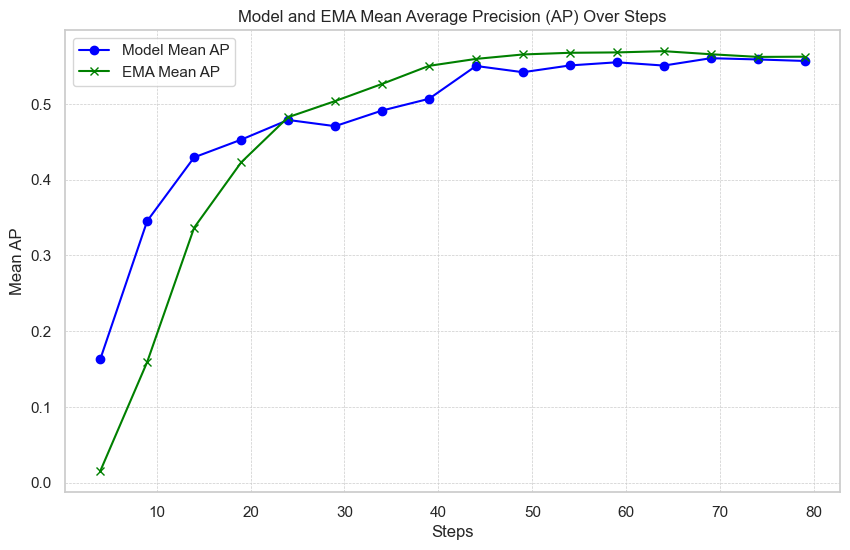

In [82]:
# Plotting the results
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.plot(df_mean['Step'], df_mean['Value'], label='Model Mean AP', color='blue', marker='o')
plt.plot(df_ema['Step'], df_ema['Value'], label='EMA Mean AP', color='green', marker='x')

plt.title('Model and EMA Mean Average Precision (AP) Over Steps')
plt.xlabel('Steps')
plt.ylabel('Mean AP')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('runs/map_csv/Loss Function V1/mean_ap.png', dpi=300)
plt.show()

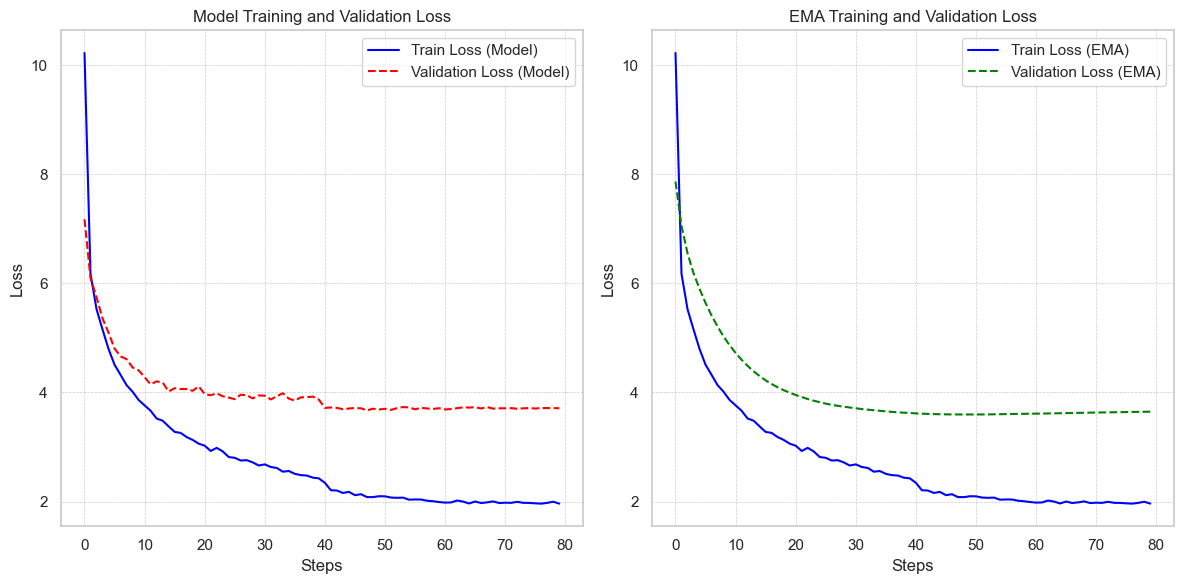

In [83]:
# Load the data from the files for loss
file_path_train_loss = 'runs/map_csv/Loss Function V1/run-.-tag-Loss_train.csv'
file_path_val_loss = 'runs/map_csv/Loss Function V1/run-.-tag-Loss_val.csv'
file_path_val_ema_loss = 'runs/map_csv/Loss Function V1/run-.-tag-Loss_val_ema.csv'

# Read the data into pandas DataFrames
df_train_loss = pd.read_csv(file_path_train_loss)
df_val_loss = pd.read_csv(file_path_val_loss)
df_val_ema_loss = pd.read_csv(file_path_val_ema_loss)

# Plotting the losses
plt.figure(figsize=(12, 6))

# Plot for model training and validation loss
plt.subplot(1, 2, 1)
plt.plot(df_train_loss['Step'], df_train_loss['Value'], label='Train Loss (Model)', color='blue')
plt.plot(df_val_loss['Step'], df_val_loss['Value'], label='Validation Loss (Model)', color='red', linestyle='--')
plt.title('Model Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for EMA training and validation loss
plt.subplot(1, 2, 2)
plt.plot(df_train_loss['Step'], df_train_loss['Value'], label='Train Loss (EMA)', color='blue')
plt.plot(df_val_ema_loss['Step'], df_val_ema_loss['Value'], label='Validation Loss (EMA)', color='green', linestyle='--')
plt.title('EMA Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('runs/map_csv/Loss Function V1/loss.png', dpi=300)
plt.show()

In [3]:
# Calculating the maximum AP for both models
max_ap_model = df_mean['Value'].max()
max_step_model = df_mean.loc[df_mean['Value'].idxmax(), 'Step']

max_ap_ema = df_ema['Value'].max()
max_step_ema = df_ema.loc[df_ema['Value'].idxmax(), 'Step']

# Creating a DataFrame to display the results in a table
max_ap_table = pd.DataFrame({
    'Model': ['Model', 'EMA'],
    'Max AP': [max_ap_model, max_ap_ema],
    'Step at Max AP': [max_step_model, max_step_ema]
})

print(max_ap_table)

   Model    Max AP  Step at Max AP
0  Model  0.560464              69
1    EMA  0.569741              64


## 3 Anchor Boxes + 3 Grid Cell sizes

In [14]:
import torch
from torch.utils.data import DataLoader

%matplotlib inline
%load_ext autoreload
%autoreload 2
## Initialization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 10

In [15]:
from albumentations.pytorch import ToTensorV2
from src_yolo_v3.dataset import YOLODataset
import albumentations as abt
import cv2

anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

scale = 1.1
train_transforms = abt.Compose(
    [
        abt.LongestMaxSize(max_size=int(416 * scale)),
        abt.PadIfNeeded(
            min_height=int(416 * scale),
            min_width=int(416 * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        abt.RandomCrop(width=416, height=416),
        abt.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        abt.OneOf(
            [
                abt.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                abt.Affine(shear=15, p=0.5, fit_output=False),
            ],
            p=1.0,
        ),
        abt.HorizontalFlip(p=0.5),
        abt.Blur(p=0.1),
        abt.CLAHE(p=0.1),
        abt.Posterize(p=0.1),
        abt.ToGray(p=0.1),
        abt.ChannelShuffle(p=0.05),
        abt.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255, ),
        ToTensorV2(),
    ],
    bbox_params=abt.BboxParams(format="yolo", min_visibility=0.4, label_fields=[], ),
)
test_transforms = abt.Compose(
    [
        abt.LongestMaxSize(max_size=416),
        abt.PadIfNeeded(
            min_height=416, min_width=416, border_mode=cv2.BORDER_CONSTANT
        ),
        abt.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255, ),
        ToTensorV2(),
    ],
    bbox_params=abt.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

train_dataset = YOLODataset(
    img_dir='data/VOCdevkit_2007/VOC2007/JPEGImages',
    label_file='data/voc2007train.txt',
    S=[13, 26, 52],
    anchors=anchors,
    transform=train_transforms,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print('Loaded %d train images' % len(train_dataset))

val_dataset = YOLODataset(
    img_dir='data/VOCdevkit_2007/VOC2007/JPEGImages/',
    label_file='data/voc2007val.txt',
    S=[13, 26, 52],
    anchors=anchors,
    transform=test_transforms,
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print('Loaded %d val images' % len(val_dataset))

Loaded 3756 train images
Loaded 1255 val images


In [16]:
from src_yolo_v3.darknet_yolo import ModelMain
from src_yolo_v3.params import config as config_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of your YOLOv3 model
model = ModelMain(config_model)

# Load the pre-trained weights
model.to(device)

ModelMain(
  (backbone): DarkNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.1)
    (layer1): Sequential(
      (ds_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (ds_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ds_relu): LeakyReLU(negative_slope=0.1)
      (residual_0): BasicBlock(
        (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): LeakyReLU(negative_slope=0.1)
        (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): LeakyReLU(negative_

In [17]:
batch_size = 10

In [18]:
from torch import optim
from yolo_loss import YoloLossV3
from torch.optim.lr_scheduler import MultiStepLR

# Assign different lr for each layer
base_params = list(
    map(id, model.backbone.parameters())
)
logits_params = filter(lambda p: id(p) not in base_params, model.parameters())

optimizer = optim.SGD(model.parameters(), momentum=0.9,
                              weight_decay=4e-05,
                              nesterov=False, lr=0.001)
criterion = YoloLossV3()

# Learning Rate Scheduler
# Reduce learning rate by a factor of 0.1 at epochs 50, 70, 90
lr_scheduler = MultiStepLR(optimizer, milestones=[50, 70, 90], gamma=0.1)

num_epochs = 100

In [19]:
anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

scaled_anchors = (
        torch.tensor(anchors)
        * torch.tensor([13, 26, 52]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(device)

scaler = torch.cuda.amp.GradScaler()

In [20]:
from ema_pytorch import EMA

alpha = 0.999  # decay factor for EMA
global_step = 0  # to keep track of the number of steps

# Initialize EMA with your model and decay rate
# Initialize EMA
ema = EMA(
    model=model,
    beta=0.9999,  # Decay rate for EMA
    update_after_step=100,  # Number of steps after which to start updating EMA
    update_every=10,  # Frequency of updates (every 10 steps)
    # Other parameters as needed
)

In [9]:
from tqdm import tqdm
from src_yolo_v3.utils import check_class_accuracy, get_evaluation_bboxes, mean_average_precision
import numpy as np
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter('runs/training')

best_map = 0.0

# Hyperparameters etc.
NMS_IOU_THRESH = 0.45
MAP_IOU_THRESH = 0.5
CONF_THRESHOLD = 0.05

anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

# Open a file to write the metrics
for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    losses = []
    # Initialize dictionaries to keep track of the sums and counts of each loss component
    loss_sums = {"no_obj": 0, "obj": 0, "box": 0, "cls": 0}
    loss_counts = {"no_obj": 0, "obj": 0, "box": 0, "cls": 0}

    writer.add_scalar('Learning_rate', optimizer.param_groups[0]['lr'], epoch)

    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(device)
        y = [y[i].to(device) for i in range(len(y))]

        with torch.cuda.amp.autocast():
            out = model(x)
            loss, loss_dict = criterion(out, y, scaled_anchors)

        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update loss sums and counts
        for k, v in loss_dict.items():
            loss_sums[k] += v
            loss_counts[k] += 1

        # Calculate mean losses
        mean_losses = {k: loss_sums[k] / loss_counts[k] for k in loss_sums}

        # Update progress bar
        mean_loss = sum(losses) / len(losses)
        postfix_dict = {'mean_loss': mean_loss}
        postfix_dict.update(mean_losses)

        loop.set_postfix(postfix_dict)

        # Update EMA after every training step
        ema.update()

    # Calculate and log mean losses after each epoch
    writer.add_scalar("Loss/train", sum(losses) / len(losses), epoch)


    if epoch > 0 and epoch % 5 == 0:
        print(f"Epoch: {epoch}")
        print(f"Model Accuracy:")
        check_class_accuracy(model, val_loader, threshold=0.05)
        print(f"EMA Accuracy:")
        check_class_accuracy(ema, val_loader, threshold=0.05)

        pred_boxes, true_boxes = get_evaluation_bboxes(
            val_loader,
            model,
            iou_threshold=NMS_IOU_THRESH,
            anchors=anchors,
            threshold=CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=20,
        )

        writer.add_scalar("AP/val_mean", mapval.item(), epoch)
        print(f"MAP: {mapval.item()}")

        if mapval > best_map:
            best_map = mapval
            torch.save(model.state_dict(), 'checkpoints/best_detector_yolov3.pth')

        pred_boxes, true_boxes = get_evaluation_bboxes(
            val_loader,
            ema,
            iou_threshold=NMS_IOU_THRESH,
            anchors=anchors,
            threshold=CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=20,
        )

        writer.add_scalar("AP/val_mean_ema", mapval.item(), epoch)
        print(f"MAP (EMA): {mapval.item()}")

        if mapval > best_map:
            best_map = mapval
            torch.save(ema.state_dict(), 'checkpoints/best_detector_yolov3_ema.pth')

        model.train()

    # Scheduler step
    lr_scheduler.step()

100%|██████████| 376/376 [02:09<00:00,  2.90it/s, mean_loss=2.56, no_obj=0.00657, obj=0.259, box=0.0756, cls=0.341]


Epoch: 5
Model Accuracy:


100%|██████████| 126/126 [00:27<00:00,  4.51it/s]


Class accuracy is: 88.761665%
No obj accuracy is: 97.099060%
Obj accuracy is: 62.383377%
EMA Accuracy:


100%|██████████| 126/126 [00:27<00:00,  4.61it/s]


Class accuracy is: 91.083542%
No obj accuracy is: 99.059723%
Obj accuracy is: 26.812977%


100%|██████████| 126/126 [04:00<00:00,  1.90s/it]


MAP: 0.28673821687698364


100%|██████████| 126/126 [02:44<00:00,  1.31s/it]


MAP (EMA): 0.11292573064565659


100%|██████████| 376/376 [02:11<00:00,  2.86it/s, mean_loss=1.81, no_obj=0.00826, obj=0.157, box=0.0639, cls=0.203]


Epoch: 10
Model Accuracy:


100%|██████████| 126/126 [00:26<00:00,  4.75it/s]


Class accuracy is: 89.408401%
No obj accuracy is: 97.794083%
Obj accuracy is: 77.905006%
EMA Accuracy:


100%|██████████| 126/126 [00:25<00:00,  4.94it/s]


Class accuracy is: 92.090759%
No obj accuracy is: 98.787598%
Obj accuracy is: 53.837997%


100%|██████████| 126/126 [04:12<00:00,  2.01s/it]


MAP: 0.3856790363788605


100%|██████████| 126/126 [02:58<00:00,  1.42s/it]


MAP (EMA): 0.37570303678512573


100%|██████████| 376/376 [02:09<00:00,  2.90it/s, mean_loss=1.54, no_obj=0.00838, obj=0.126, box=0.057, cls=0.161] 


Epoch: 15
Model Accuracy:


100%|██████████| 126/126 [00:25<00:00,  4.99it/s]


Class accuracy is: 89.694656%
No obj accuracy is: 97.903183%
Obj accuracy is: 83.418152%
EMA Accuracy:


100%|██████████| 126/126 [00:25<00:00,  4.93it/s]


Class accuracy is: 92.589058%
No obj accuracy is: 98.547302%
Obj accuracy is: 69.963951%


100%|██████████| 126/126 [04:11<00:00,  2.00s/it]


MAP: 0.4952767789363861


100%|██████████| 126/126 [03:08<00:00,  1.50s/it]


MAP (EMA): 0.5030959248542786


100%|██████████| 376/376 [02:14<00:00,  2.79it/s, mean_loss=1.35, no_obj=0.0081, obj=0.111, box=0.0527, cls=0.125] 


Epoch: 20
Model Accuracy:


100%|██████████| 126/126 [00:24<00:00,  5.09it/s]


Class accuracy is: 89.259964%
No obj accuracy is: 98.427429%
Obj accuracy is: 82.930450%
EMA Accuracy:


100%|██████████| 126/126 [00:25<00:00,  5.04it/s]


Class accuracy is: 92.716286%
No obj accuracy is: 98.489952%
Obj accuracy is: 78.000427%


100%|██████████| 126/126 [03:31<00:00,  1.68s/it]


MAP: 0.5431991219520569


100%|██████████| 126/126 [03:54<00:00,  1.86s/it]


MAP (EMA): 0.5824975967407227


100%|██████████| 376/376 [02:20<00:00,  2.67it/s, mean_loss=1.14, no_obj=0.00761, obj=0.0988, box=0.0499, cls=0.0819]


Epoch: 25
Model Accuracy:


100%|██████████| 126/126 [00:28<00:00,  4.36it/s]


Class accuracy is: 89.525017%
No obj accuracy is: 98.354851%
Obj accuracy is: 84.414757%
EMA Accuracy:


100%|██████████| 126/126 [00:28<00:00,  4.37it/s]


Class accuracy is: 92.938927%
No obj accuracy is: 98.521942%
Obj accuracy is: 82.188293%


100%|██████████| 126/126 [03:47<00:00,  1.81s/it]


MAP: 0.5200515985488892


100%|██████████| 126/126 [03:06<00:00,  1.48s/it]


MAP (EMA): 0.6145959496498108


100%|██████████| 376/376 [02:08<00:00,  2.92it/s, mean_loss=1.09, no_obj=0.00738, obj=0.0895, box=0.0472, cls=0.0825]


Epoch: 30
Model Accuracy:


100%|██████████| 126/126 [00:26<00:00,  4.78it/s]


Class accuracy is: 88.761665%
No obj accuracy is: 98.790283%
Obj accuracy is: 82.092873%
EMA Accuracy:


100%|██████████| 126/126 [00:26<00:00,  4.81it/s]


Class accuracy is: 92.981339%
No obj accuracy is: 98.591194%
Obj accuracy is: 84.245125%


100%|██████████| 126/126 [03:00<00:00,  1.43s/it]


MAP: 0.5219486951828003


100%|██████████| 126/126 [03:03<00:00,  1.45s/it]


MAP (EMA): 0.6339202523231506


100%|██████████| 376/376 [02:10<00:00,  2.88it/s, mean_loss=1.03, no_obj=0.00703, obj=0.0816, box=0.0444, cls=0.0811]


Epoch: 35
Model Accuracy:


100%|██████████| 126/126 [00:25<00:00,  4.90it/s]


Class accuracy is: 90.256569%
No obj accuracy is: 98.840576%
Obj accuracy is: 82.506355%
EMA Accuracy:


100%|██████████| 126/126 [00:25<00:00,  4.93it/s]


Class accuracy is: 92.885918%
No obj accuracy is: 98.672249%
Obj accuracy is: 85.125107%


100%|██████████| 126/126 [02:53<00:00,  1.38s/it]


MAP: 0.5765380859375


100%|██████████| 126/126 [02:45<00:00,  1.31s/it]


MAP (EMA): 0.6400378942489624


100%|██████████| 376/376 [02:01<00:00,  3.11it/s, mean_loss=1.03, no_obj=0.00684, obj=0.0811, box=0.0434, cls=0.0845]


Epoch: 40
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.27it/s]


Class accuracy is: 90.055130%
No obj accuracy is: 98.852448%
Obj accuracy is: 82.124680%
EMA Accuracy:


100%|██████████| 126/126 [00:24<00:00,  5.17it/s]


Class accuracy is: 92.854111%
No obj accuracy is: 98.732307%
Obj accuracy is: 85.400764%


100%|██████████| 126/126 [02:34<00:00,  1.23s/it]


MAP: 0.5797803997993469


100%|██████████| 126/126 [02:34<00:00,  1.22s/it]


MAP (EMA): 0.6420379281044006


100%|██████████| 376/376 [02:01<00:00,  3.09it/s, mean_loss=0.858, no_obj=0.00659, obj=0.0711, box=0.0402, cls=0.0487]


Epoch: 45
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.34it/s]


Class accuracy is: 89.270569%
No obj accuracy is: 98.981232%
Obj accuracy is: 81.562767%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.36it/s]


Class accuracy is: 93.034348%
No obj accuracy is: 98.798874%
Obj accuracy is: 85.241730%


100%|██████████| 126/126 [02:30<00:00,  1.19s/it]


MAP: 0.5578405261039734


100%|██████████| 126/126 [02:31<00:00,  1.21s/it]


MAP (EMA): 0.6512514352798462


100%|██████████| 376/376 [02:01<00:00,  3.09it/s, mean_loss=0.749, no_obj=0.00645, obj=0.0629, box=0.036, cls=0.0325] 


Epoch: 50
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.33it/s]


Class accuracy is: 90.924515%
No obj accuracy is: 99.089050%
Obj accuracy is: 81.626381%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.36it/s]


Class accuracy is: 92.938927%
No obj accuracy is: 98.860321%
Obj accuracy is: 85.072098%


100%|██████████| 126/126 [02:21<00:00,  1.12s/it]


MAP: 0.6270080208778381


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


MAP (EMA): 0.6620497107505798


100%|██████████| 376/376 [02:01<00:00,  3.10it/s, mean_loss=0.678, no_obj=0.00612, obj=0.0593, box=0.0338, cls=0.0211]


Epoch: 55
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.27it/s]


Class accuracy is: 91.263786%
No obj accuracy is: 99.145699%
Obj accuracy is: 81.371925%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.33it/s]


Class accuracy is: 92.822304%
No obj accuracy is: 98.924767%
Obj accuracy is: 84.648010%


100%|██████████| 126/126 [02:18<00:00,  1.10s/it]


MAP: 0.6392428874969482


100%|██████████| 126/126 [02:25<00:00,  1.15s/it]


MAP (EMA): 0.661746084690094


100%|██████████| 376/376 [02:01<00:00,  3.10it/s, mean_loss=0.662, no_obj=0.00592, obj=0.0557, box=0.0339, cls=0.021] 


Epoch: 60
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.32it/s]


Class accuracy is: 91.178963%
No obj accuracy is: 99.213593%
Obj accuracy is: 80.322304%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.30it/s]


Class accuracy is: 92.578461%
No obj accuracy is: 98.982994%
Obj accuracy is: 84.128502%


100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


MAP: 0.6360436677932739


100%|██████████| 126/126 [02:21<00:00,  1.12s/it]


MAP (EMA): 0.6633123159408569


100%|██████████| 376/376 [02:01<00:00,  3.10it/s, mean_loss=0.642, no_obj=0.00586, obj=0.0564, box=0.0329, cls=0.0167]


Epoch: 65
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Class accuracy is: 91.486427%
No obj accuracy is: 99.206688%
Obj accuracy is: 80.343506%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.36it/s]


Class accuracy is: 92.440628%
No obj accuracy is: 99.032555%
Obj accuracy is: 83.524170%


100%|██████████| 126/126 [02:15<00:00,  1.07s/it]


MAP: 0.6559134721755981


100%|██████████| 126/126 [02:20<00:00,  1.12s/it]


MAP (EMA): 0.6592517495155334


100%|██████████| 376/376 [02:01<00:00,  3.10it/s, mean_loss=0.636, no_obj=0.00587, obj=0.0547, box=0.0322, cls=0.0182]


Epoch: 70
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.35it/s]


Class accuracy is: 91.518234%
No obj accuracy is: 99.226372%
Obj accuracy is: 80.269295%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.36it/s]


Class accuracy is: 92.345207%
No obj accuracy is: 99.073906%
Obj accuracy is: 82.983459%


100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


MAP: 0.648938775062561


100%|██████████| 126/126 [02:17<00:00,  1.09s/it]


MAP (EMA): 0.6603214740753174


100%|██████████| 376/376 [02:01<00:00,  3.09it/s, mean_loss=0.627, no_obj=0.00582, obj=0.0537, box=0.0321, cls=0.0168] 


Epoch: 75
Model Accuracy:


100%|██████████| 126/126 [00:24<00:00,  5.21it/s]


Class accuracy is: 91.454628%
No obj accuracy is: 99.231049%
Obj accuracy is: 80.057251%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.29it/s]


Class accuracy is: 92.217979%
No obj accuracy is: 99.105705%
Obj accuracy is: 82.506355%


100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


MAP: 0.6494499444961548


100%|██████████| 126/126 [02:15<00:00,  1.08s/it]


MAP (EMA): 0.6622908115386963


100%|██████████| 376/376 [02:01<00:00,  3.09it/s, mean_loss=0.638, no_obj=0.00578, obj=0.054, box=0.0325, cls=0.0198] 


Epoch: 80
Model Accuracy:


100%|██████████| 126/126 [00:24<00:00,  5.25it/s]


Class accuracy is: 91.539444%
No obj accuracy is: 99.244026%
Obj accuracy is: 80.099663%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.33it/s]


Class accuracy is: 92.186180%
No obj accuracy is: 99.131889%
Obj accuracy is: 82.114082%


100%|██████████| 126/126 [02:12<00:00,  1.05s/it]


MAP: 0.6556906700134277


100%|██████████| 126/126 [02:14<00:00,  1.06s/it]


MAP (EMA): 0.6612923741340637


100%|██████████| 376/376 [02:01<00:00,  3.08it/s, mean_loss=0.627, no_obj=0.00574, obj=0.0542, box=0.0325, cls=0.016] 


Epoch: 85
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Class accuracy is: 91.539444%
No obj accuracy is: 99.243805%
Obj accuracy is: 80.142067%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.32it/s]


Class accuracy is: 92.069550%
No obj accuracy is: 99.153267%
Obj accuracy is: 81.743004%


100%|██████████| 126/126 [02:12<00:00,  1.05s/it]


MAP: 0.6479690074920654


100%|██████████| 126/126 [02:17<00:00,  1.09s/it]


MAP (EMA): 0.6587609052658081


100%|██████████| 376/376 [02:05<00:00,  2.99it/s, mean_loss=0.632, no_obj=0.00565, obj=0.056, box=0.0322, cls=0.0175] 


Epoch: 90
Model Accuracy:


100%|██████████| 126/126 [00:24<00:00,  5.09it/s]


Class accuracy is: 91.518234%
No obj accuracy is: 99.239326%
Obj accuracy is: 80.120865%
EMA Accuracy:


100%|██████████| 126/126 [00:24<00:00,  5.14it/s]


Class accuracy is: 91.974136%
No obj accuracy is: 99.171516%
Obj accuracy is: 81.435539%


100%|██████████| 126/126 [02:19<00:00,  1.11s/it]


MAP: 0.6545906066894531


100%|██████████| 126/126 [02:18<00:00,  1.10s/it]


MAP (EMA): 0.6565752029418945


100%|██████████| 376/376 [02:02<00:00,  3.07it/s, mean_loss=0.63, no_obj=0.0057, obj=0.0534, box=0.0324, cls=0.0186]  


Epoch: 95
Model Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Class accuracy is: 91.486427%
No obj accuracy is: 99.245049%
Obj accuracy is: 79.887619%
EMA Accuracy:


100%|██████████| 126/126 [00:23<00:00,  5.32it/s]


Class accuracy is: 91.878716%
No obj accuracy is: 99.185722%
Obj accuracy is: 81.223495%


100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


MAP: 0.6561969518661499


100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


MAP (EMA): 0.6580578088760376


100%|██████████| 376/376 [02:00<00:00,  3.11it/s, mean_loss=0.63, no_obj=0.00569, obj=0.053, box=0.0323, cls=0.0192]  


In [21]:
ema.load_state_dict(torch.load('checkpoints/best_detector_yolov3_ema.pth'))

<All keys matched successfully>

In [9]:
anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

val_dataset = YOLODataset(
    img_dir='data/VOCdevkit_2007/VOC2007/JPEGImages/',
    label_file='data/voc2007val.txt',
    S=[13, 26, 52],
    anchors=anchors,
    transform=test_transforms,
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print('Loaded %d val images' % len(val_dataset))

Loaded 1255 val images


In [10]:
from src_yolo_v3.utils import check_class_accuracy, get_evaluation_bboxes, mean_average_precision

print(f"EMA Accuracy:")
check_class_accuracy(ema, val_loader, threshold=0.05)

pred_boxes, true_boxes = get_evaluation_bboxes(
    val_loader,
    ema,
    iou_threshold=0.55,
    anchors=anchors,
    threshold=0.05,
)
mapval = mean_average_precision(
    pred_boxes,
    true_boxes,
    iou_threshold=0.5,
    box_format="midpoint",
    num_classes=20,
)

print(f"MAP (EMA): {mapval.item()}")

EMA Accuracy:


100%|██████████| 126/126 [00:41<00:00,  3.05it/s]


Class accuracy is: 92.578461%
No obj accuracy is: 98.982994%
Obj accuracy is: 84.128502%


100%|██████████| 126/126 [02:37<00:00,  1.25s/it]


MAP (EMA): 0.6650133728981018


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the files
file_path_ema = 'runs/map_csv/Loss Function V3b/run-.-tag-AP_val_mean_ema.csv'
file_path_mean = 'runs/map_csv/Loss Function V3b/run-.-tag-AP_val_mean.csv'

# Read the data into pandas DataFrames
df_ema = pd.read_csv(file_path_ema)
df_mean = pd.read_csv(file_path_mean)

# Ensure the data is correctly loaded
df_ema.head(), df_mean.head()

(      Wall time  Step     Value
 0  1.701239e+09     5  0.112926
 1  1.701240e+09    10  0.375703
 2  1.701241e+09    15  0.503096
 3  1.701242e+09    20  0.582498
 4  1.701244e+09    25  0.614596,
       Wall time  Step     Value
 0  1.701239e+09     5  0.286738
 1  1.701240e+09    10  0.385679
 2  1.701241e+09    15  0.495277
 3  1.701242e+09    20  0.543199
 4  1.701243e+09    25  0.520052)

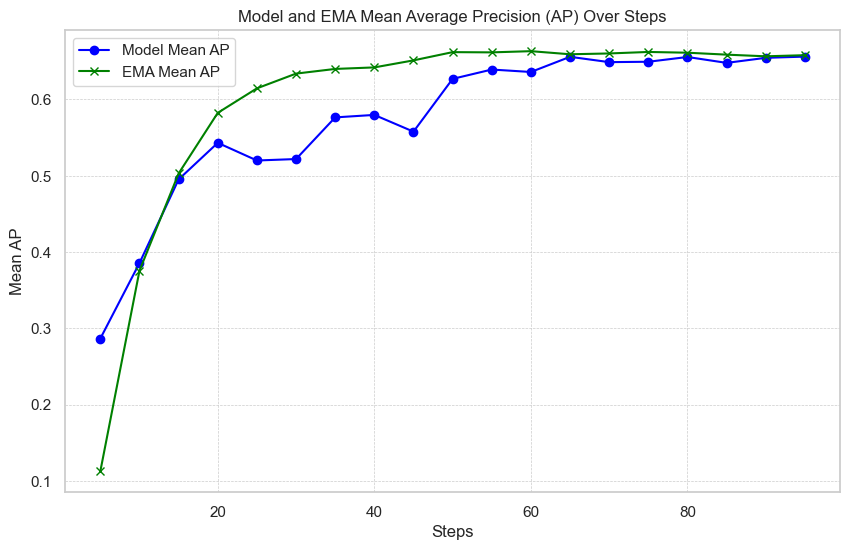

In [34]:
# Plotting the results
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.plot(df_mean['Step'], df_mean['Value'], label='Model Mean AP', color='blue', marker='o')
plt.plot(df_ema['Step'], df_ema['Value'], label='EMA Mean AP', color='green', marker='x')

plt.title('Model and EMA Mean Average Precision (AP) Over Steps')
plt.xlabel('Steps')
plt.ylabel('Mean AP')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('runs/map_csv/Loss Function V3/mean_ap.png', dpi=300)
plt.show()

In [35]:
# Calculating the maximum AP for both models
max_ap_model = df_mean['Value'].max()
max_step_model = df_mean.loc[df_mean['Value'].idxmax(), 'Step']

max_ap_ema = df_ema['Value'].max()
max_step_ema = df_ema.loc[df_ema['Value'].idxmax(), 'Step']

# Creating a DataFrame to display the results in a table
max_ap_table = pd.DataFrame({
    'Model': ['Model', 'EMA'],
    'Max AP': [max_ap_model, max_ap_ema],
    'Step at Max AP': [max_step_model, max_step_ema]
})

print(max_ap_table)

   Model    Max AP  Step at Max AP
0  Model  0.656197              95
1    EMA  0.663312              60


In [11]:
test_dataset = YOLODataset(
    img_dir='data/VOCdevkit_2007/VOC2007test/JPEGImages/',
    label_file='data/voc2007test.txt',
    S=[13, 26, 52],
    anchors=anchors,
    transform=test_transforms,
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Loaded 4950 test images


[[14.0, 0.8809224963188171, 0.5034810900688171, 0.5212082862854004, 1.0120594501495361, 1.0020047426223755]]


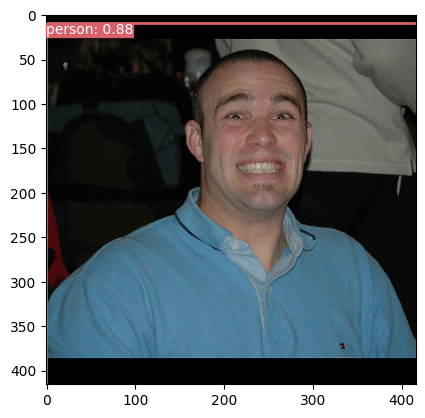

[[0.0, 0.8242748379707336, 0.8767445683479309, 0.3974100351333618, 0.09477519243955612, 0.0846678763628006]]


[[6.0, 0.80379718542099, 0.44810858368873596, 0.4765375852584839, 0.7467066049575806, 0.5281587243080139], [14.0, 0.8022075891494751, 0.14055612683296204, 0.42194250226020813, 0.22052371501922607, 0.6020481586456299]]


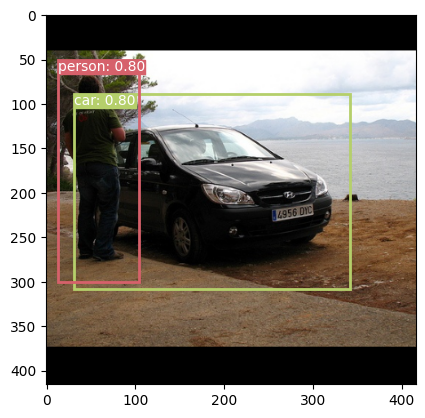

[[7.0, 0.8316488862037659, 0.6298304796218872, 0.565401017665863, 0.7519145607948303, 0.7326067090034485]]


[[11.0, 0.7697170376777649, 0.4827134311199188, 0.518204927444458, 0.40950748324394226, 0.7105908393859863]]


[[6.0, 0.9404748678207397, 0.21255545318126678, 0.5830042362213135, 0.44840022921562195, 0.6172277927398682], [6.0, 0.9296437501907349, 0.7930477857589722, 0.4005573093891144, 0.2137303501367569, 0.13281913101673126], [14.0, 0.8434436321258545, 0.4952624440193176, 0.579290509223938, 0.40786388516426086, 0.6087954640388489], [6.0, 0.8271982073783875, 0.37613001465797424, 0.3929901719093323, 0.15334360301494598, 0.17013348639011383], [6.0, 0.7928339242935181, 0.756744384765625, 0.6370403170585632, 0.6025266647338867, 0.5271186828613281]]


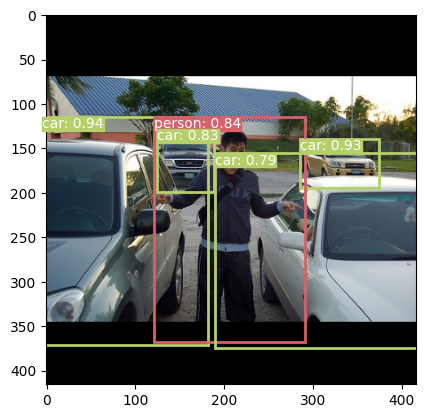

[[14.0, 0.8414518237113953, 0.17684777081012726, 0.7035577297210693, 0.18421266973018646, 0.3516521453857422], [0.0, 0.8374149203300476, 0.5039066076278687, 0.4050115942955017, 1.0093294382095337, 0.7485687732696533], [14.0, 0.7934750318527222, 0.8972115516662598, 0.7085984349250793, 0.21231496334075928, 0.3892441689968109]]


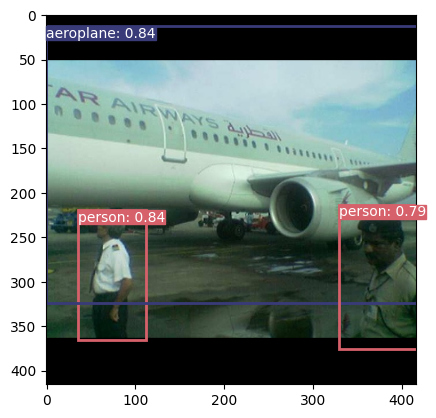

[[1.0, 0.8371932506561279, 0.49963894486427307, 0.4336439073085785, 0.935598611831665, 0.689507782459259]]


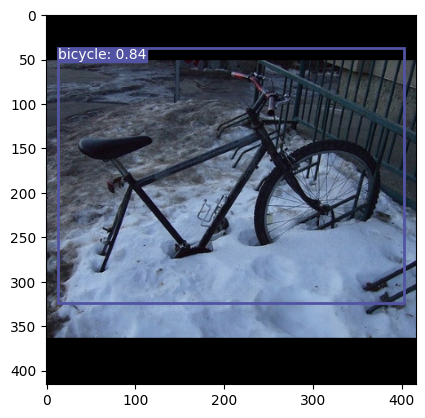

[[8.0, 0.7917443513870239, 0.49508023262023926, 0.49809226393699646, 1.0632601976394653, 0.8638561964035034], [14.0, 0.7730444669723511, 0.430894136428833, 0.6553152203559875, 0.5015803575515747, 0.4748888611793518], [17.0, 0.7351443767547607, 0.4877595007419586, 0.4890826344490051, 1.0586929321289062, 0.9256085753440857]]


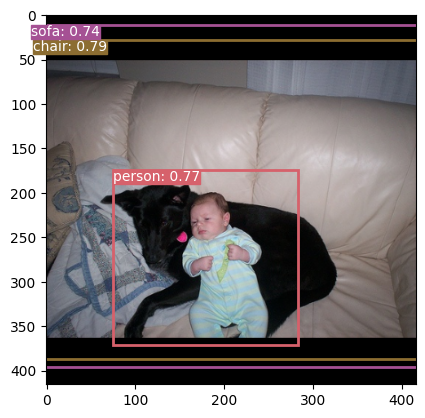

[[14.0, 0.7820137739181519, 0.5033798217773438, 0.5006307363510132, 0.36653149127960205, 0.6958484053611755], [12.0, 0.7580861449241638, 0.43909114599227905, 0.6317475438117981, 0.705490231513977, 0.49794143438339233], [14.0, 0.7526613473892212, 0.9701479077339172, 0.6626774668693542, 0.07946200668811798, 0.23161400854587555], [12.0, 0.6787192225456238, 0.08649541437625885, 0.6627420783042908, 0.23517510294914246, 0.38713574409484863]]


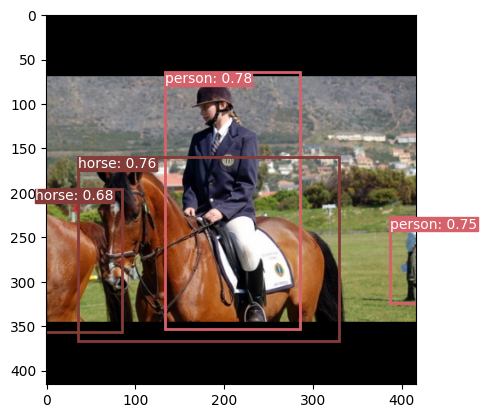

In [16]:
from src_yolo_v3.utils import plot_couple_examples

plot_couple_examples(ema, test_loader, 0.5, 0.5, scaled_anchors)

predicting...
['car', 0.9404748678207397, -5, 53, 218, 361]
['car', 0.9296437501907349, 343, 83, 449, 149]
['person', 0.8434436321258545, 145, 53, 349, 357]
['car', 0.8271982073783875, 149, 69, 226, 155]
['car', 0.7928339242935181, 227, 102, 529, 366]


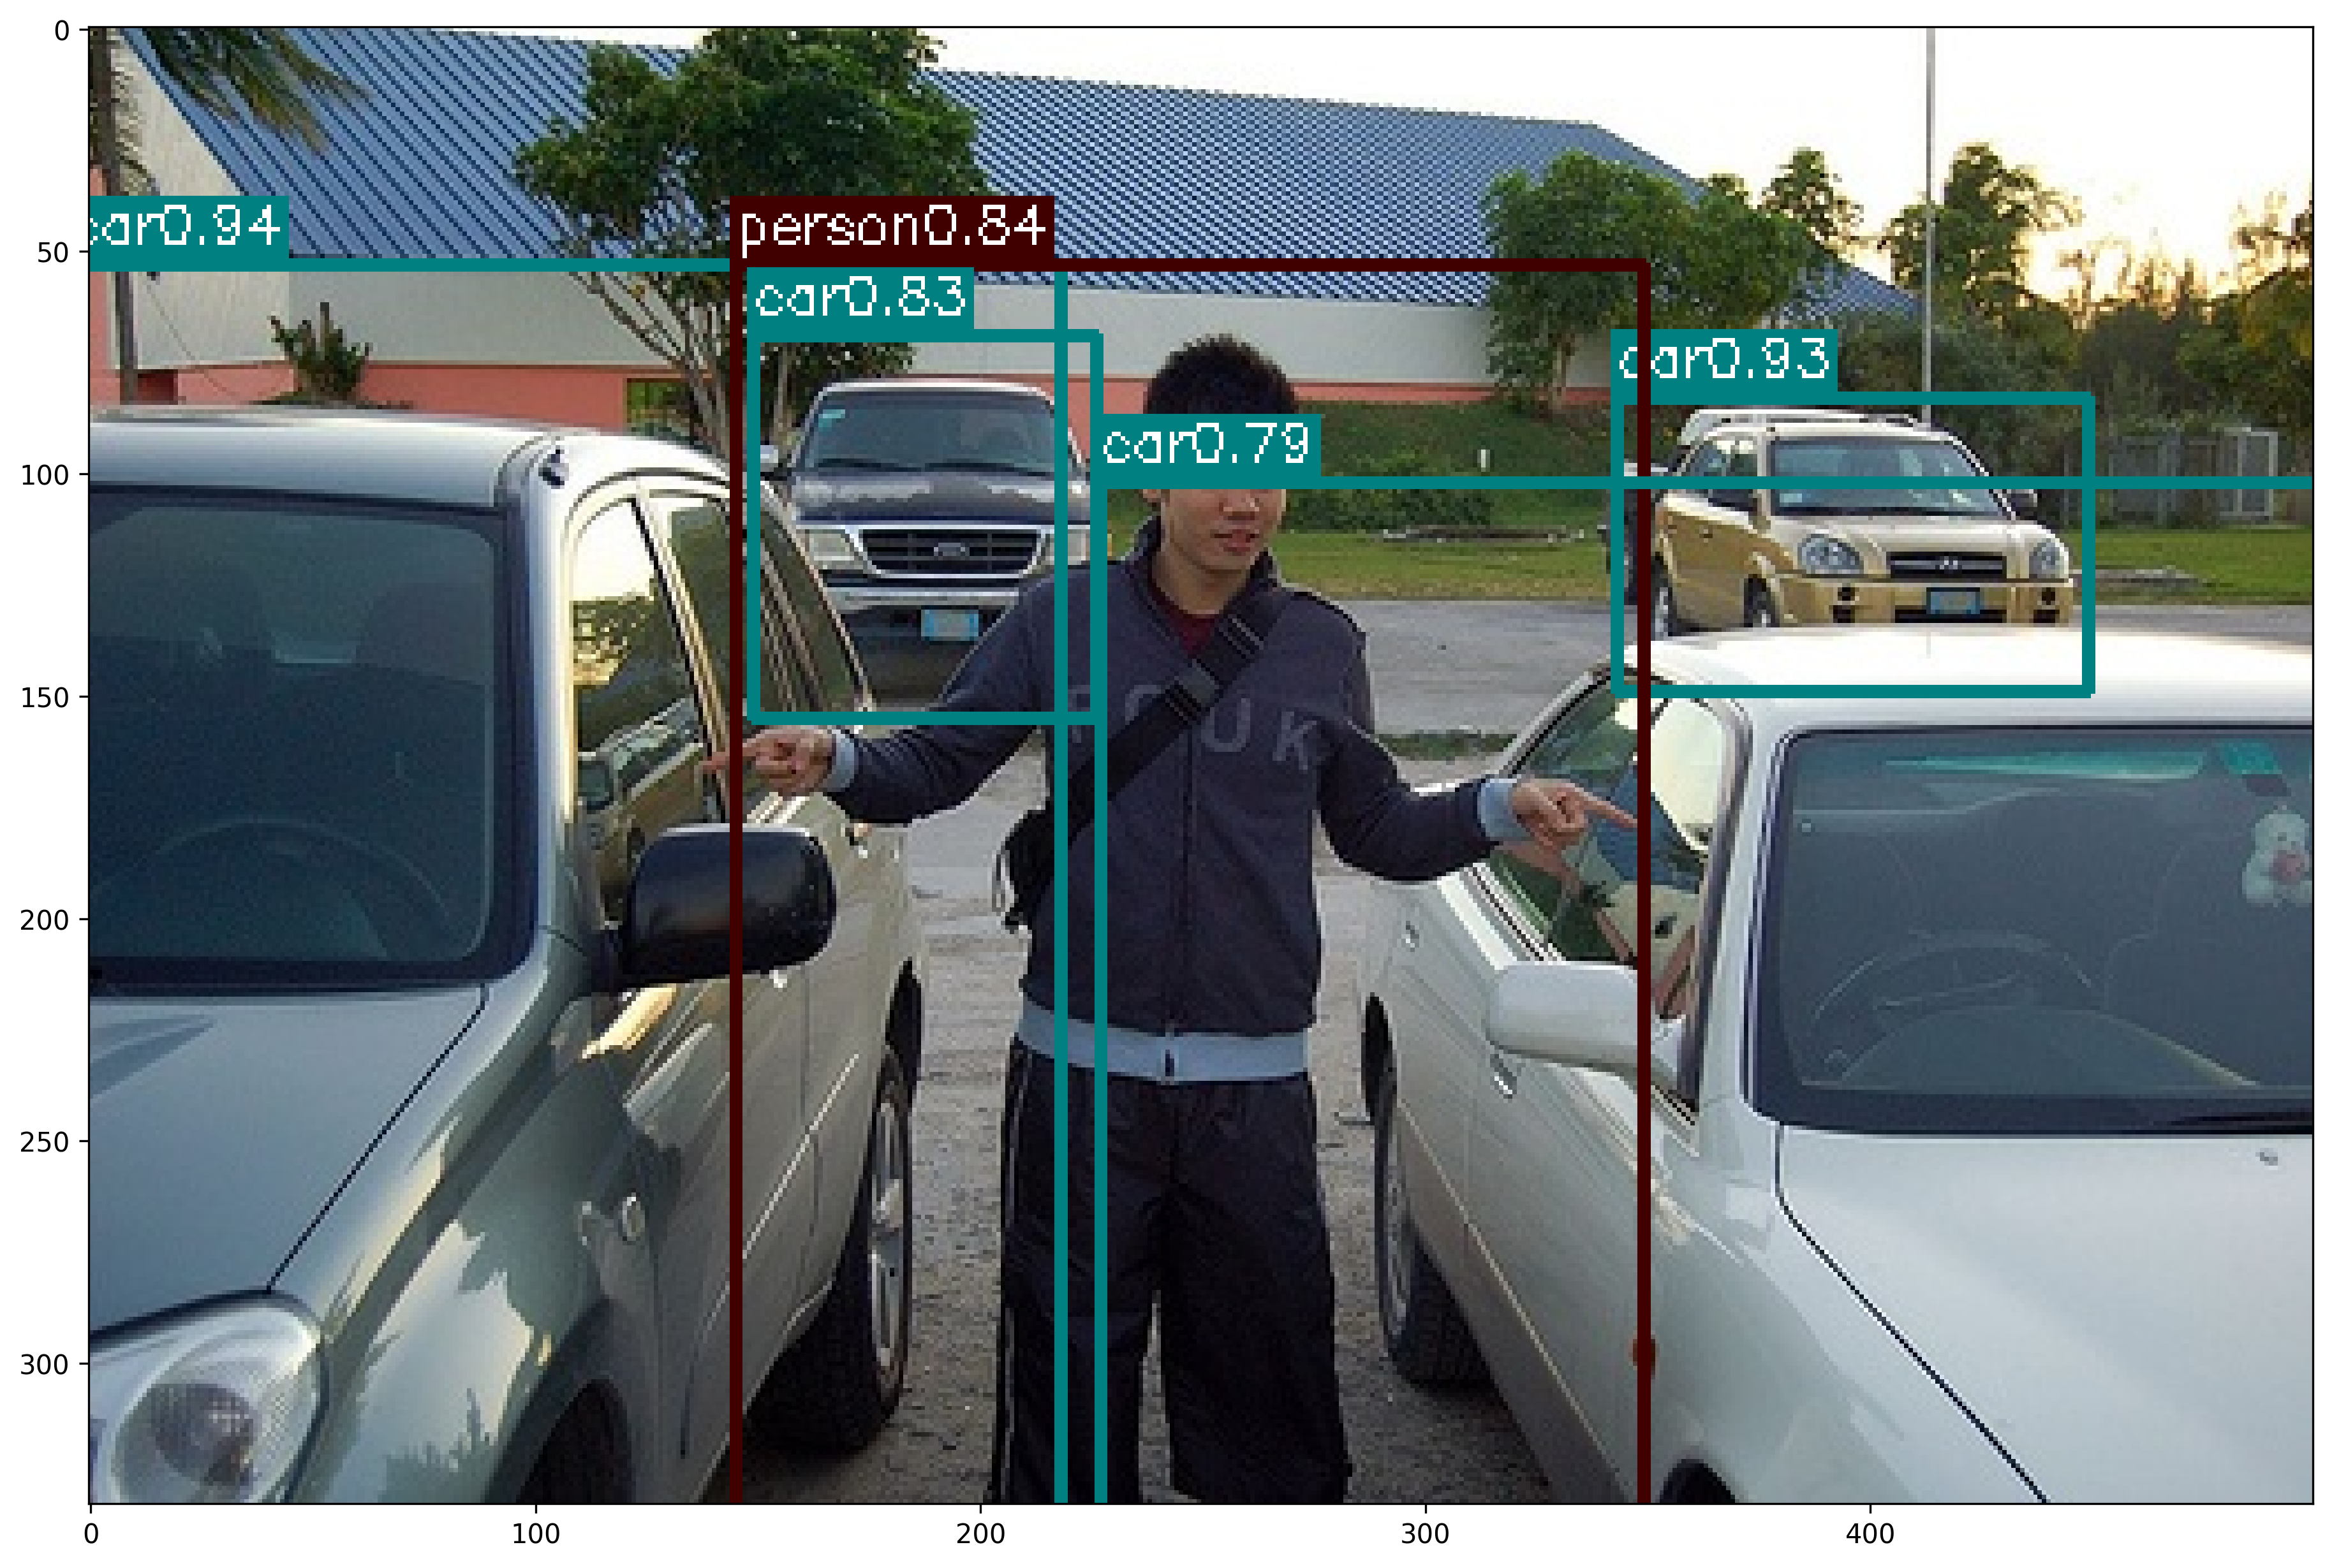

In [17]:
import cv2
import matplotlib.pyplot as plt
from src.config import VOC_CLASSES, COLORS

# select random image from val set
image = cv2.imread('data/VOCdevkit_2007/VOC2007test/JPEGImages/003385.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.style.use('default')

result = [[6.0, 0.9404748678207397, 0.21255545318126678, 0.5830042362213135, 0.44840022921562195, 0.6172277927398682], [6.0, 0.9296437501907349, 0.7930477857589722, 0.4005573093891144, 0.2137303501367569, 0.13281913101673126], [14.0, 0.8434436321258545, 0.4952624440193176, 0.579290509223938, 0.40786388516426086, 0.6087954640388489], [6.0, 0.8271982073783875, 0.37613001465797424, 0.3929901719093323, 0.15334360301494598, 0.17013348639011383], [6.0, 0.7928339242935181, 0.756744384765625, 0.6370403170585632, 0.6025266647338867, 0.5271186828613281]]
print('predicting...')
for class_name, prob, x, y, w, h in result:
    class_name = VOC_CLASSES[int(class_name)]
    color = COLORS[VOC_CLASSES.index(class_name)]

    max_side = max(image.shape[0], image.shape[1])
    offset_x = (max_side - image.shape[1]) / 2
    offset_y = (max_side - image.shape[0]) / 2
    x1, y1 = (int((x - w / 2) * max_side - offset_x), int((y - h / 2) * max_side - offset_y))
    x2, y2 = (int((x + w / 2) * max_side - offset_x), int((y + h / 2) * max_side - offset_y))
    print([class_name, prob, x1, y1, x2, y2])
    left_up = (x1, y1)
    right_bottom = (x2, y2)

    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize=(15, 15), dpi=300)
plt.imshow(image)

In [13]:
from src_yolo_v3.utils import cells_to_bboxes
from src_yolo_v3.utils import non_max_suppression
from tqdm import tqdm

def get_predict_bboxes(
    loader,
    model,
    iou_threshold,
    anchors,
    threshold,
    box_format="midpoint",
    device="cuda",
):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            train_idx += 1

    model.train()
    return all_pred_boxes

In [27]:
test_boxes = get_predict_bboxes(test_loader, ema, 0.55, anchors, 0.05)

100%|██████████| 495/495 [09:10<00:00,  1.11s/it]


In [28]:
test_dataset.labels[:5]

['002824.jpg\n',
 '000473.jpg\n',
 '000358.jpg\n',
 '006052.jpg\n',
 '004758.jpg\n']

In [29]:
test_boxes[:10]

[[0,
  14.0,
  0.8809224963188171,
  0.5034810900688171,
  0.5212082862854004,
  1.0120594501495361,
  1.0020047426223755],
 [1,
  0.0,
  0.8242748379707336,
  0.8767445683479309,
  0.3974100351333618,
  0.09477519243955612,
  0.0846678763628006],
 [1,
  0.0,
  0.32073110342025757,
  0.9066851735115051,
  0.3965315818786621,
  0.11274266988039017,
  0.09274543821811676],
 [1,
  0.0,
  0.31191694736480713,
  0.8922639489173889,
  0.40148821473121643,
  0.07534223049879074,
  0.06640899926424026],
 [1,
  0.0,
  0.1528300940990448,
  0.8597496747970581,
  0.38217079639434814,
  0.12368069589138031,
  0.10962070524692535],
 [1,
  0.0,
  0.12403713911771774,
  0.8755553364753723,
  0.42490851879119873,
  0.09304076433181763,
  0.09532679617404938],
 [1,
  0.0,
  0.07289618253707886,
  0.8686455488204956,
  0.38103243708610535,
  0.06397279351949692,
  0.05282899737358093],
 [1,
  3.0,
  0.06062896549701691,
  0.12485171109437943,
  0.529240071773529,
  0.27533769607543945,
  0.5267415046691

In [30]:
import csv

# Initialize predictions with all image names
predictions = {filename.strip(): [] for filename in test_dataset.labels}

for image_id, class_name, prob, x, y, w, h in test_boxes:
    class_name = VOC_CLASSES[int(class_name)]
    image_name = test_dataset.labels[image_id].strip()

    image = cv2.imread(f'data/VOCdevkit_2007/VOC2007test/JPEGImages/{image_name}')
    width, height = image.shape[1], image.shape[0]

    x1 = int((x - w / 2) * width)
    y1 = int((y - h / 2) * height)
    x2 = int((x + w / 2) * width)
    y2 = int((y + h / 2) * height)

    pred = [class_name, prob, x1, y1, x2, y2]
    if image_name not in predictions:
        predictions[image_name] = []
    predictions[image_name].append(pred)

# Writing to CSV
with open('predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'image_id', 'prediction_list'])

    for idx, (image_id, preds) in enumerate(predictions.items(), 1):
        formatted_preds = str(preds).replace(' ', '')  # Format predictions
        writer.writerow([idx, image_id, formatted_preds])

print(f"Total images processed: {len(predictions)}")

Total images processed: 4950


person 0.8809224963188171 -1 8 504 440


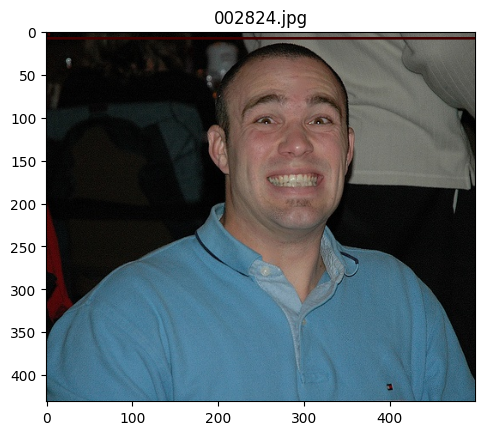

aeroplane 0.8242748379707336 414 133 462 164
aeroplane 0.32073110342025757 425 131 481 166
aeroplane 0.31191694736480713 427 138 464 163
aeroplane 0.1528300940990448 398 122 460 163
aeroplane 0.12403713911771774 414 141 461 177
aeroplane 0.07289618253707886 418 132 450 152
boat 0.06062896549701691 -6 99 131 297
aeroplane 0.06016339361667633 393 137 442 168


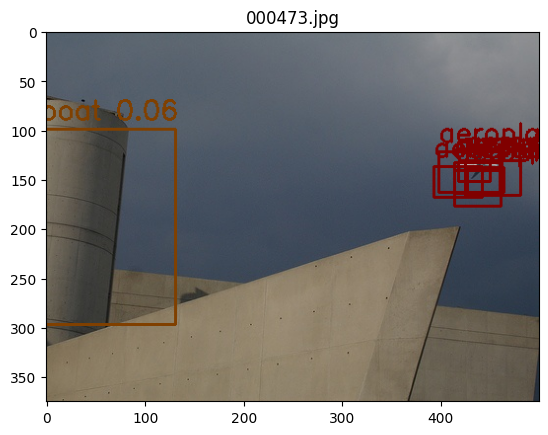

car 0.80379718542099 37 84 410 296
person 0.8022075891494751 15 48 125 289


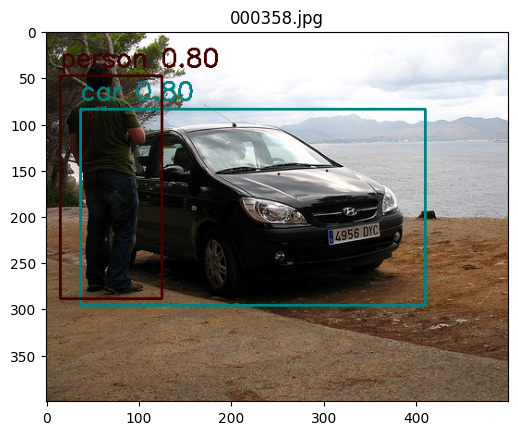

cat 0.8316488862037659 126 74 502 349
bottle 0.4171249568462372 418 120 514 275
bottle 0.12603645026683807 440 103 511 220
person 0.08113943785429001 0 68 24 147


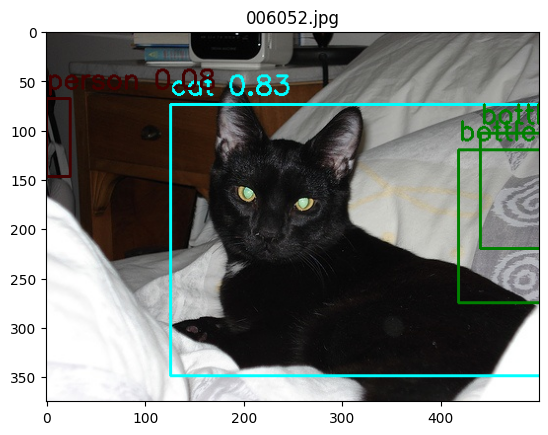

dog 0.7697170376777649 51 53 126 286
bird 0.40738967061042786 127 64 144 90
bird 0.3256790041923523 74 1 90 16
bird 0.16877064108848572 129 58 148 87
bird 0.05300914868712425 124 69 141 98


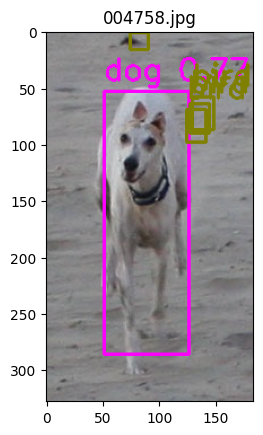

In [32]:
import csv
import cv2
import os
import matplotlib.pyplot as plt

plt.style.use('default')

# Load predictions from CSV
predictions = {}
with open('predictions.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        image_id, prediction_list = row[1], eval(row[2])
        predictions[image_id] = prediction_list

# Plot some images with predictions
for image_id, preds in list(predictions.items())[:5]:
    image_path = os.path.join('data/VOCdevkit_2007/VOC2007test/JPEGImages/', image_id)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for pred in preds:
        class_name, prob, x1, y1, x2, y2 = pred
        print(class_name, prob, x1, y1, x2, y2)
        color = COLORS[VOC_CLASSES.index(class_name)]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f'{class_name} {prob:.2f}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    plt.imshow(image)
    plt.title(image_id)
    plt.show()

# Run Yolo On Video

In [12]:
# !yt-dlp https://www.youtube.com/watch?v=xZGahvrep3o

[youtube] Extracting URL: https://www.youtube.com/watch?v=xZGahvrep3o
[youtube] xZGahvrep3o: Downloading webpage
[youtube] xZGahvrep3o: Downloading ios player API JSON
[youtube] xZGahvrep3o: Downloading android player API JSON
[youtube] xZGahvrep3o: Downloading m3u8 information
[info] xZGahvrep3o: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 42
[download] Destination: SNL Digital Short： YOLO - SNL [xZGahvrep3o].f616.mp4

[download] 100.0% of ~   712.00B at    1.34KiB/s ETA Unknown (frag 0/42)
[download]   1.2% of ~  58.41KiB at    1.34KiB/s ETA Unknown (frag 1/42)
[download]  11.6% of ~  14.60KiB at    2.65KiB/s ETA Unknown (frag 1/42)
[download]  10.4% of ~  35.60KiB at    2.65KiB/s ETA Unknown (frag 1/42)
[download]   9.9% of ~  77.60KiB at    2.65KiB/s ETA Unknown (frag 1/42)
[download]   9.7% of ~ 161.60KiB at    2.65KiB/s ETA Unknown (frag 1/42)
[download]   9.6% of ~ 329.60KiB at    2.65KiB/s ETA Unknown (frag 1/42)
[download

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x219ef6b2580>
C:\Users\eddie\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=3>
  return process_handler(cmd, _system_body)
C:\Users\eddie\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=4>
  return process_handler(cmd, _system_body)
C:\Users\eddie\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)


In [2]:
import cv2
import os

# Create the directory if it doesn't exist
output_dir = 'data/VideoFrames'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the video file
video_stream = cv2.VideoCapture('SNL Digital Short： YOLO - SNL [xZGahvrep3o].webm')

# Get FPS of the video
fps = video_stream.get(cv2.CAP_PROP_FPS)

# Prepare to write frame filenames to a text file
frame_list_filename = os.path.join(output_dir, "frames_list.txt")
with open(frame_list_filename, 'w') as frame_list_file:

    # Read and save frames
    frame_idx = 0
    while video_stream.isOpened():
        ret, frame = video_stream.read()
        if not ret:
            break

        # Save every frame that corresponds to 20 FPS
        if frame_idx % int(fps / 20) == 0:
            frame_filename = f"frame_{frame_idx}.jpg"
            full_frame_path = os.path.join(output_dir, frame_filename)
            cv2.imwrite(full_frame_path, frame)
            frame_list_file.write(frame_filename + '\n')

        frame_idx += 1

# Release the video stream
video_stream.release()

In [12]:
video_dataset = YOLODataset(
    img_dir='data/VideoFrames',
    label_file='data/frames_list.txt',
    S=[13, 26, 52],
    anchors=anchors,
    transform=test_transforms,
)
video_loader = DataLoader(video_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print('Loaded %d test images' % len(video_dataset))

Loaded 5265 test images


In [14]:
video_boxes = get_predict_bboxes(video_loader, ema, 0.3, anchors, 0.5)

100%|██████████| 527/527 [06:12<00:00,  1.41it/s]


In [15]:
image_path = os.path.join('data/VideoFrames', 'frame_0.jpg')
image = cv2.imread(image_path)
image.shape

(1080, 1920, 3)

In [16]:
import csv

# Initialize predictions with all image names
predictions = {filename.strip(): [] for filename in video_dataset.labels}

for image_id, class_name, prob, x, y, w, h in video_boxes:
    class_name = VOC_CLASSES[int(class_name)]
    image_name = video_dataset.labels[image_id].strip()

    width, height = image.shape[1], image.shape[0]

    max_side = max(image.shape[0], image.shape[1])
    offset_x = (max_side - image.shape[1]) / 2
    offset_y = (max_side - image.shape[0]) / 2
    x1, y1 = (int((x - w / 2) * max_side - offset_x), int((y - h / 2) * max_side - offset_y))
    x2, y2 = (int((x + w / 2) * max_side - offset_x), int((y + h / 2) * max_side - offset_y))

    pred = [class_name, prob, x1, y1, x2, y2]
    if image_name not in predictions:
        predictions[image_name] = []
    predictions[image_name].append(pred)

# Writing to CSV
with open('video_box.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'image_id', 'prediction_list'])

    for idx, (image_id, preds) in enumerate(predictions.items(), 1):
        formatted_preds = str(preds).replace(' ', '')  # Format predictions
        writer.writerow([idx, image_id, formatted_preds])

print(f"Total images processed: {len(predictions)}")

Total images processed: 5265


In [17]:
import cv2
import csv
import os
from src.config import VOC_CLASSES, COLORS

# Load predictions from CSV
predictions = {}
with open('video_box.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        image_id, prediction_list = row[1], eval(row[2])
        predictions[image_id] = prediction_list

# Annotate and save images
output_dir = 'data/AnnotatedVideoFrames'
os.makedirs(output_dir, exist_ok=True)

for image_id, preds in list(predictions.items()):
    image_path = os.path.join('data/VideoFrames', image_id)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for pred in preds:
        class_name, prob, x1, y1, x2, y2 = pred
        color_index = VOC_CLASSES.index(class_name)
        color = COLORS[color_index]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        label = f'{class_name} {prob:.2f}'
        (label_width, label_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
        cv2.rectangle(image, (x1, y1 - label_height - baseline), (x1 + label_width, y1), color, -1)
        cv2.putText(image, label, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    # Convert back to BGR for saving with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(output_dir, image_id), image)

In [4]:
import cv2
import os
from moviepy.editor import VideoFileClip, AudioFileClip, concatenate_videoclips

# Part 1: Create a video from images
image_folder = 'data/AnnotatedVideoFrames'
video_name = 'annotated_video.avi'
images = [img for img in sorted(os.listdir(image_folder), key=lambda index: int(index.split('_')[1].split('.')[0])) if img.endswith(".jpg")]
images[-10:]

['frame_5255.jpg',
 'frame_5256.jpg',
 'frame_5257.jpg',
 'frame_5258.jpg',
 'frame_5259.jpg',
 'frame_5260.jpg',
 'frame_5261.jpg',
 'frame_5262.jpg',
 'frame_5263.jpg',
 'frame_5264.jpg']

In [6]:
from moviepy.editor import VideoFileClip

# Load original video to get its duration and frame rate
video_clip = VideoFileClip('SNL Digital Short： YOLO - SNL [xZGahvrep3o].webm')
duration = video_clip.duration  # Duration in seconds
fps = video_clip.fps  # Frames per second

# Calculate total number of frames
total_frames = duration * fps

# Number of extracted frames (images)
extracted_frames = 5265

# Calculate the ratio
frame_ratio = total_frames / extracted_frames
frame_ratio, fps

(1.0001622309314617, 23.976023976023978)

In [7]:
from tqdm import tqdm

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, 0, fps, (width, height))

# Writing images to the video file with progress display
for image in tqdm(images, desc="Creating Video"):
    video.write(cv2.imread(os.path.join(image_folder, image)))
video.release()

Creating Video: 100%|██████████| 5265/5265 [07:00<00:00, 12.51it/s]


In [8]:
# Part 2: Add audio from original video to the new video
original_video = VideoFileClip('SNL Digital Short： YOLO - SNL [xZGahvrep3o].webm')
new_video = VideoFileClip(video_name)
final_video = new_video.set_audio(original_video.audio)
final_video.write_videofile('final_video.mp4', codec='libx264')

Moviepy - Building video final_video.mp4.
MoviePy - Writing audio in final_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video final_video.mp4



Moviepy - Done !
Moviepy - video ready final_video.mp4


In [8]:
# !yt-dlp https://www.youtube.com/watch?v=GtL1huin9EE

[youtube] Extracting URL: https://www.youtube.com/watch?v=GtL1huin9EE
[youtube] GtL1huin9EE: Downloading webpage
[youtube] GtL1huin9EE: Downloading ios player API JSON
[youtube] GtL1huin9EE: Downloading android player API JSON
[youtube] GtL1huin9EE: Downloading m3u8 information
[info] GtL1huin9EE: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 13
[download] Destination: InsurAAAnce & Rick Astley Never Gonna Give You Up [GtL1huin9EE].f616.mp4

[download] 100.0% of ~   712.00B at    284.80B/s ETA Unknown (frag 0/13)
[download]   3.8% of ~  18.08KiB at    284.80B/s ETA Unknown (frag 1/13)
[download]  37.5% of ~   4.52KiB at    605.60B/s ETA 00:02 (frag 1/13)  
[download]  33.5% of ~  11.02KiB at    605.60B/s ETA 00:02 (frag 1/13)
[download]  32.0% of ~  24.02KiB at    605.60B/s ETA 00:02 (frag 1/13)
[download]  31.4% of ~  50.02KiB at    605.60B/s ETA 00:02 (frag 1/13)
[download]  31.1% of ~ 102.02KiB at    7.49KiB/s ETA 00:02 (frag 1/1

In [9]:
import cv2
import os

# Create the directory if it doesn't exist
output_dir = 'data/VideoFrames'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the video file
video_stream = cv2.VideoCapture('InsurAAAnce & Rick Astley Never Gonna Give You Up [GtL1huin9EE].webm')

# Get FPS of the video
fps = video_stream.get(cv2.CAP_PROP_FPS)

fps

23.979552093476144

In [10]:
# Prepare to write frame filenames to a text file
frame_list_filename = os.path.join(output_dir, "frames_list.txt")
with open(frame_list_filename, 'w') as frame_list_file:
    # Read and save frames
    frame_idx = 0
    while video_stream.isOpened():
        ret, frame = video_stream.read()
        if not ret:
            break

        # Save every frame that corresponds to 20 FPS
        if frame_idx % int(fps / 20) == 0:
            frame_filename = f"frame_{frame_idx}.jpg"
            full_frame_path = os.path.join(output_dir, frame_filename)
            cv2.imwrite(full_frame_path, frame)
            frame_list_file.write(frame_filename + '\n')

        frame_idx += 1

# Release the video stream
video_stream.release()

In [11]:
from src_yolo_v3 import config
from src_yolo_v3.dataset import YOLODataset
from torch.utils.data import DataLoader

transform = config.test_transforms
video_dataset = YOLODataset(
    img_dir='data/VideoFrames',
    label_file='data/frames_list.txt',
    S=[13, 26, 52],
    anchors=config.ANCHORS,
    transform=transform,
)
video_loader = DataLoader(video_dataset, batch_size=10, shuffle=False, num_workers=2)
print('Loaded %d test images' % len(video_dataset))

Loaded 1548 test images


In [22]:
from src_yolo_v3.utils import get_predict_bboxes

video_boxes = get_predict_bboxes(video_loader, ema, 0.3, config.ANCHORS, 0.5)
image_path = os.path.join('data/VideoFrames', 'frame_0.jpg')
image = cv2.imread(image_path)
image.shape

100%|██████████| 155/155 [01:24<00:00,  1.84it/s]


(1080, 1920, 3)

In [24]:
import csv
from src.config import VOC_CLASSES

# Initialize predictions with all image names
predictions = {filename.strip(): [] for filename in video_dataset.labels}

for image_id, class_name, prob, x, y, w, h in video_boxes:
    class_name = VOC_CLASSES[int(class_name)]
    image_name = video_dataset.labels[image_id].strip()

    width, height = image.shape[1], image.shape[0]

    max_side = max(image.shape[0], image.shape[1])
    offset_x = (max_side - image.shape[1]) / 2
    offset_y = (max_side - image.shape[0]) / 2
    x1, y1 = (int((x - w / 2) * max_side - offset_x), int((y - h / 2) * max_side - offset_y))
    x2, y2 = (int((x + w / 2) * max_side - offset_x), int((y + h / 2) * max_side - offset_y))

    pred = [class_name, prob, x1, y1, x2, y2]
    if image_name not in predictions:
        predictions[image_name] = []
    predictions[image_name].append(pred)

# Writing to CSV
with open('video_box.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'image_id', 'prediction_list'])

    for idx, (image_id, preds) in enumerate(predictions.items(), 1):
        formatted_preds = str(preds).replace(' ', '')  # Format predictions
        writer.writerow([idx, image_id, formatted_preds])

print(f"Total images processed: {len(predictions)}")

Total images processed: 1548


In [25]:
import cv2
import csv
import os
from src.config import VOC_CLASSES, COLORS

# Load predictions from CSV
predictions = {}
with open('video_box.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        image_id, prediction_list = row[1], eval(row[2])
        predictions[image_id] = prediction_list

# Annotate and save images
output_dir = 'data/AnnotatedVideoFrames'
os.makedirs(output_dir, exist_ok=True)

for image_id, preds in list(predictions.items()):
    image_path = os.path.join('data/VideoFrames', image_id)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for pred in preds:
        class_name, prob, x1, y1, x2, y2 = pred
        color_index = VOC_CLASSES.index(class_name)
        color = COLORS[color_index]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        label = f'{class_name} {prob:.2f}'
        (label_width, label_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
        cv2.rectangle(image, (x1, y1 - label_height - baseline), (x1 + label_width, y1), color, -1)
        cv2.putText(image, label, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    # Convert back to BGR for saving with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(output_dir, image_id), image)

In [26]:
import cv2
import os
from moviepy.editor import VideoFileClip, AudioFileClip, concatenate_videoclips

# Part 1: Create a video from images
image_folder = 'data/AnnotatedVideoFrames'
video_name = 'annotated_video.avi'
images = [img for img in sorted(os.listdir(image_folder), key=lambda index: int(index.split('_')[1].split('.')[0])) if
          img.endswith(".jpg")]
images[-10:]

['frame_1538.jpg',
 'frame_1539.jpg',
 'frame_1540.jpg',
 'frame_1541.jpg',
 'frame_1542.jpg',
 'frame_1543.jpg',
 'frame_1544.jpg',
 'frame_1545.jpg',
 'frame_1546.jpg',
 'frame_1547.jpg']

In [27]:
from moviepy.editor import VideoFileClip

# Load original video to get its duration and frame rate
video_clip = VideoFileClip('InsurAAAnce & Rick Astley Never Gonna Give You Up [GtL1huin9EE].webm')
duration = video_clip.duration  # Duration in seconds
fps = video_clip.fps  # Frames per second

# Calculate total number of frames
total_frames = duration * fps

# Number of extracted frames (images)
extracted_frames = 1548

# Calculate the ratio
frame_ratio = total_frames / extracted_frames
frame_ratio, fps

(1.0007047216349543, 23.976023976023978)

In [28]:
from tqdm import tqdm

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, 0, fps, (width, height))

# Writing images to the video file with progress display
for image in tqdm(images, desc="Creating Video"):
    video.write(cv2.imread(os.path.join(image_folder, image)))
video.release()
# Part 2: Add audio from original video to the new video
original_video = VideoFileClip('InsurAAAnce & Rick Astley Never Gonna Give You Up [GtL1huin9EE].webm')
new_video = VideoFileClip(video_name)
final_video = new_video.set_audio(original_video.audio)
final_video.write_videofile('final_video_2.mp4', codec='libx264')

Creating Video: 100%|██████████| 1548/1548 [01:04<00:00, 24.01it/s]


Moviepy - Building video final_video_2.mp4.
MoviePy - Writing audio in final_video_2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video final_video_2.mp4



Moviepy - Done !
Moviepy - video ready final_video_2.mp4
